# Богданов Александр Иванович, Б05-003

## Вариационный автокодировщик

In [238]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [239]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Вспомогательные функции

In [240]:
def generate_clusters(number_clusters=3, vector_size=8, number_samples=5000, mu_range=(-10, 10), sigma_range=(0.1, 1)):
    clusters = []
    for i in range(number_clusters):
        mu = np.random.uniform(mu_range[0], mu_range[1], vector_size)
#         sigma = np.random.uniform(sigma_range[0], sigma_range[1], (vector_size, vector_size))
#         sigma = np.dot(sigma, sigma.transpose())
        sigma = np.eye(vector_size)
        cluster = np.random.multivariate_normal(mu, sigma, number_samples)
        clusters.extend(cluster)
        
    data = torch.Tensor(clusters)
    
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=11)
    return TensorDataset(train_data, train_data), TensorDataset(test_data, test_data)

In [241]:
def plot_data(data):
    plt.figure(figsize=(8, 6))
    plt.hist2d(data[:, 0], data[:, 1], bins=50)
    plt.xlabel('1 Компонента')
    plt.ylabel('2 Компонента')
    plt.show()

In [242]:
def check(batch_size, dataset, model, loss_function):
    
    model.eval()
    
    batch_generator = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size)
            
    test_loss = 0
    for it, (x_batch, y_batch) in enumerate(batch_generator):
        x_batch = x_batch.to(model.device)
        y_batch = y_batch.to(model.device)

        output = model(x_batch)

        test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)
        
    test_loss /= len(dataset)

    print(f'loss: {test_loss}')
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

    data, _ = next(iter(dataloader))
    data = data.numpy()
    plot_data(data)
    
    data = model.generate_samples(5000).cpu().data.numpy()
    plot_data(data)
    
    return test_loss

In [243]:
def train_on_batch(model, x_batch, optimizer):
    model.train()
    optimizer.zero_grad()
    loss = model.loss(x_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [244]:
def train_epoch(train_generator, model, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, _) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, optimizer)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [245]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

In [246]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter = 300, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        model.eval()
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            model.eval()
            
            batch_generator = torch.utils.data.DataLoader(dataset=self.dataset, batch_size=self.batch_size)
            
            test_loss = 0
            for it, (x_batch, _) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)

                output = model(x_batch)

                test_loss += self.loss_function(output, x_batch).cpu().item()*len(x_batch)

            
            test_loss /= len(self.dataset)

            print(f"\t\tstep={self.step}, train_loss={loss}, val_loss={test_loss}")
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)

    def __call__(self, model, loss):
        return self.forward(model, loss)

## Модель

In [247]:
class VAE(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, latent_dim, input_dim, hidden_dim=1000):
        """
        Standart model of VAE with ELBO optimization.
        Args:
            latent_dim: int - the dimension of latent space.
            input_dim: int - the dimension of input space.
            hidden_dim: int - the size of hidden_dim neural layer.
        Returns:
            None
        Example:
            >>> model = VAE(2, 10)
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim

        self.proposal_z = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, hidden_dim),
            torch.nn.LeakyReLU()
        )
        self.proposal_mu_z = torch.nn.Linear(hidden_dim, self.latent_dim)
        self.proposal_sigma_z = torch.nn.Linear(hidden_dim, self.latent_dim)

        self.proposal_x = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_dim),
            torch.nn.LeakyReLU()
        )
        self.proposal_mu_x = torch.nn.Linear(hidden_dim, self.input_dim)
        self.proposal_sigma_x = torch.nn.Linear(hidden_dim, self.input_dim)
        
    def q_z(self, x):
        """
        Generates distribution of z provided x.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
            mu: Tensor - the matrix of shape batch_size x latent_dim.
            sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Example:
            >>>
        """
        x = x.to(self.device)

        proposal = self.proposal_z(x)
        mu = self.proposal_mu_z(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma_z(proposal))
        return mu, sigma

    def p_z(self, num_samples):
        """
        Generetes prior distribution of z.
        Args:
            num_samples: int - the number of samples.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape num_samples x latent_dim.
            	sigma: Tensor - the matrix of shape num_samples x latent_dim.
        Example:
            >>>
        """
        mu = torch.zeros([num_samples, self.latent_dim], device=self.device)
        sigma = torch.ones([num_samples, self.latent_dim], device=self.device)
        return mu, sigma

    def sample_z(self, distr, num_samples=1):
        """
        Generates samples from normal distribution q(z|x).
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            num_samples: int - the number of samples for each element.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x latent_dim - samples from normal distribution in latent space.
        Example:
            >>>
        """
        mu, sigma = distr
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        batch_size = mu.shape[0]

        bias = mu.view([batch_size, 1, self.latent_dim])

        epsilon = torch.randn([batch_size, num_samples, self.latent_dim], requires_grad=True, device=self.device)
        scale = sigma.view([batch_size, 1, self.latent_dim])

        return bias + epsilon * scale
    
    def q_x(self, z):
        """
        Given the latent representation matrix z, returns the matrix of Normal distribution parameters for sampling x objects.
        Args:
            z: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples from latent space.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x input_dim, Normal distribution parameters.
        Example:
            >>>
        """
        z = z.to(self.device)

        proposal = self.proposal_x(z)
        mu = self.proposal_mu_x(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma_x(proposal))
        return mu, sigma

    def loss(self, batch_x):
        """
        Calculate ELBO approximation of log likelihood for given batch with negative sign.
        Args:
            batch_x: FloatTensor - the matrix of shape batch_size x input_dim.
            batch_y: FloatTensor - dont uses parameter in this model.
        Returns:
            Tensor - scalar, ELBO approximation of log likelihood for given batch with negative sign.
        Example:
            >>>
        """
        batch_x = batch_x.to(self.device)

        batch_size = batch_x.shape[0]
        
        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_size)

        z = self.sample_z(propos_distr)

        mu, sigma = self.q_x(z)
        epsilon = torch.randn([batch_size, z.shape[1], self.input_dim], requires_grad=True, device=self.device)
        pred_x = mu + sigma * epsilon

        expectation = torch.mean(self.log_mean_exp(self.log_likelihood(batch_x, pred_x)), dim=0)
        divergence = self.divergence_KL_normal(propos_distr, pri_distr)

        return -1 * torch.mean(expectation - divergence, dim=0)

    
    def generate_samples(self, num_samples):
        """
        Generate samples of object x from noises in latent space.
        Args:
            num_samples: int - the number of samples, witch need to generate.
        Returns:
            Tensor - the matrix of shape num_samples x input_dim.
        Example:
            >>>
        """
        distr_z = self.p_z(num_samples=1)
        z = self.sample_z(distr_z, num_samples=num_samples)

        mu, sigma = self.q_x(z)
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        bias = mu.view([num_samples, self.input_dim])
        epsilon = torch.randn([num_samples, self.input_dim], requires_grad=True, device=self.device)
        scale = sigma.view([num_samples, self.input_dim])

        return (mu + sigma * epsilon)[0]
        
    @staticmethod
    def log_pdf_normal(distr, samples):
        """
        The function calculates the logarithm of the probability density at a point relative to the corresponding normal distribution given componentwise by its mean and standard deviation.
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            samples: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples in latent space.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples, each element of which is the logarithm of the probability density of a point relative to the corresponding distribution.
        Example:
            >>>
        """
        mu, sigma = distr

        batch_size = mu.shape[0]
        latent_dim = mu.shape[1]

        f1 = torch.sum(((samples - mu.view([batch_size, 1, latent_dim]))**2) /
                       sigma.view([batch_size, 1, latent_dim])**2, dim=2)
        f2 = mu.shape[1] * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=1).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3

    @staticmethod
    def log_likelihood(x_true, x_distr):
        """
        Calculate log likelihood between x_true and x_distr.
        Args:
            x_true:  Tensor - the matrix of shape batch_size x input_dim.
            x_distr: Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples - log likelihood for each sample.
        Example:
            >>>
        """
        return -torch.sum((x_true.view(x_distr.shape[0], 1, x_distr.shape[2]) - x_distr) ** 2, dim=2)

    @staticmethod
    def log_mean_exp(data):
        """
        Args:
            data: Tensor - the tensor of shape n_1 x n_2 x ... x n_K.
        Returns:
            Tensor - the tensor of shape n_1 x n_2 x ,,, x n_{K - 1}.
        Example:
            >>>
        """
        return torch.logsumexp(data, dim=-1) - torch.log(torch.Tensor([data.shape[-1]]).to(data.device))
    
    @staticmethod
    def divergence_KL_normal(q_distr, p_distr):
        """
        Calculate KL-divergence KL(q||p) between n-pairs of normal distribution.
        Args:
            q_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            p_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Returns:
            Tensor - the vector of shape n, each value of which is a KL-divergence between pair of normal distribution.
        Example:
            >>>
        """
        q_mu, q_sigma = q_distr
        p_mu, p_sigma = p_distr

        D_KL = torch.sum((q_sigma / p_sigma)**2, dim=1)
        D_KL -= p_mu.shape[1]
        D_KL += 2 * torch.sum(torch.log(p_sigma), dim=1) - 2 * torch.sum(torch.log(q_sigma), dim=1)
        D_KL += torch.sum((p_mu - q_mu) * (p_mu - q_mu) / (p_sigma**2), dim=1)
        return 0.5 * D_KL
    
    def forward(self, x):
        """
        Generate decoded sample after encoding.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            Tensor - the matrix of shape batch_size x input_dim.
        Example:
            >>>
        """
        mu, _ = self.q_x(self.sample_z(self.q_z(x)))
        return mu

## Подключим tensorboard

In [248]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_4/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Обучение

In [249]:
optimizer = torch.optim.Adam
loss_function = torch.nn.MSELoss()

In [255]:
latent_dim_list = [5, 10, 15]
input_dim_list = [10, 20, 30]
relationship_list = [0.5, 1, 2]
hidden_dim_list = [300, 700, 1000]

latent_dim = 5
loss: 39.98792544555664


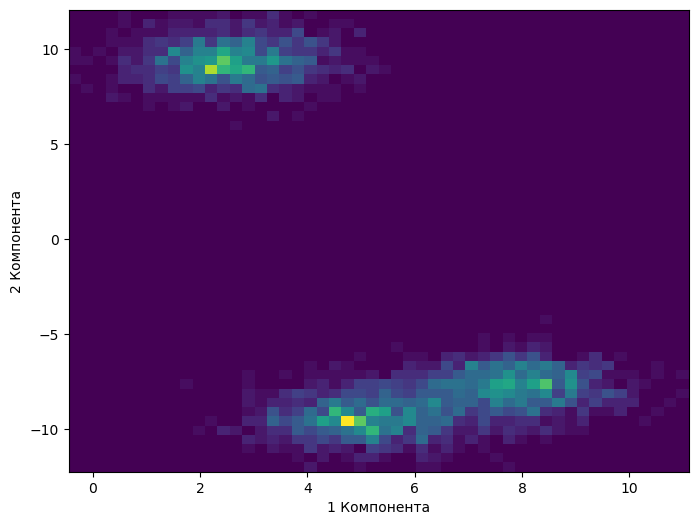

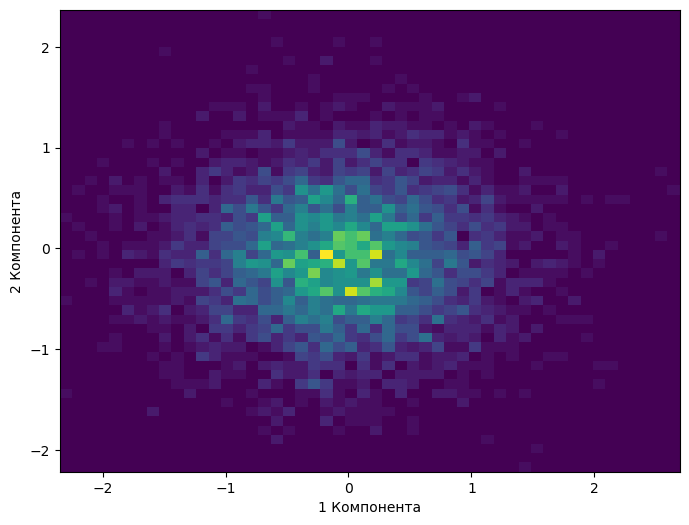

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=30.625364303588867, val_loss=58.553733052571616


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=31.33429527282715, val_loss=60.907311177571614


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=34.24796676635742, val_loss=60.04719101969401


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=27.030181884765625, val_loss=57.286592274983725


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=28.48293685913086, val_loss=58.45550236002604


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=28.01072120666504, val_loss=59.823461934407554


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=27.812278747558594, val_loss=57.66807919311523


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=25.703617095947266, val_loss=58.564717173258465


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=26.407434463500977, val_loss=58.54319393920898


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=24.858322143554688, val_loss=58.97370196533203


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=26.251985549926758, val_loss=59.036992635091146


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=24.58233642578125, val_loss=59.98910647583008


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=25.828166961669922, val_loss=59.54979685465495


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=23.894756317138672, val_loss=58.85145975748698


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=23.840267181396484, val_loss=58.2317062479655


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=26.62412452697754, val_loss=59.26516573079427


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=24.849313735961914, val_loss=58.84982755533854


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=23.566959381103516, val_loss=59.15137139892578


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=23.981121063232422, val_loss=59.243932484944665


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=23.140657424926758, val_loss=59.037798848470054


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=23.269874572753906, val_loss=59.05980126953125


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=24.09371566772461, val_loss=59.40102648925781


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=23.42812156677246, val_loss=58.84270178222656


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=22.857284545898438, val_loss=59.24032298787435


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=23.740224838256836, val_loss=59.09553230794271


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=22.663915634155273, val_loss=59.17718362426758


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=24.366910934448242, val_loss=58.65756602986654


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=22.586284637451172, val_loss=58.79838075764974


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=22.178560256958008, val_loss=59.17303978474935


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=22.885406494140625, val_loss=59.014425099690754


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=22.896617889404297, val_loss=59.18187411499024


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=22.207277297973633, val_loss=59.08278853352864


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=22.825927734375, val_loss=58.874686024983724


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=22.14078140258789, val_loss=59.017137095133464


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=20.910884857177734, val_loss=58.55498422241211


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=21.369298934936523, val_loss=58.4521955464681


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=21.7824649810791, val_loss=59.16648334757487


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=21.74568748474121, val_loss=59.61071151733398


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=22.050024032592773, val_loss=58.82677124023437


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=23.44167137145996, val_loss=59.45357321166992


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=24.383026123046875, val_loss=59.384288686116534


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=21.478687286376953, val_loss=59.292994903564455


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=21.57032585144043, val_loss=59.13153091430664


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=21.667011260986328, val_loss=58.83753433227539


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=20.880043029785156, val_loss=59.70236700439453


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=21.801502227783203, val_loss=58.95252266438802


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=23.257272720336914, val_loss=58.876968495686846


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=20.024078369140625, val_loss=59.13559267171224


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=22.207386016845703, val_loss=59.28854554239909


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=23.10927391052246, val_loss=58.980712473551435


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=23.173341751098633, val_loss=58.87381577555338


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=21.416656494140625, val_loss=59.079156127929686


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=21.315629959106445, val_loss=58.71234274291992


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=22.077699661254883, val_loss=58.58667124430338


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=22.026344299316406, val_loss=58.97685576375326


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=21.870439529418945, val_loss=58.6873317972819


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=21.947235107421875, val_loss=58.71136798095703


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=23.15241241455078, val_loss=59.26272321573893


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=21.650171279907227, val_loss=58.97353880818685


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=22.20179557800293, val_loss=59.10688222249349


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=21.145660400390625, val_loss=58.7016506652832


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=22.452253341674805, val_loss=58.8833156229655


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 59.1120105082194


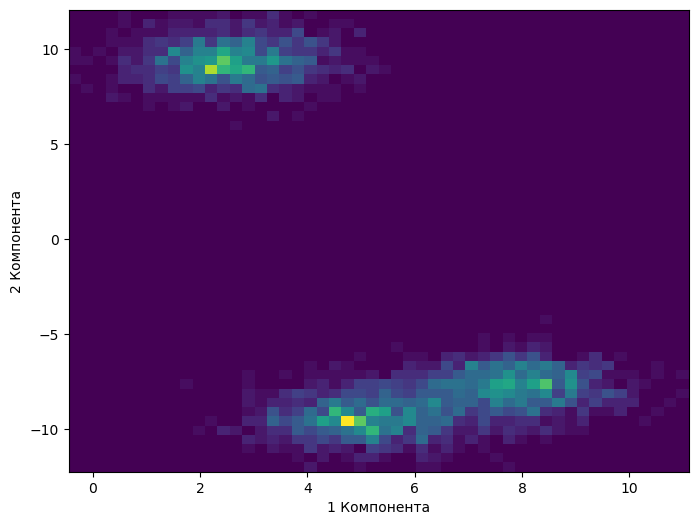

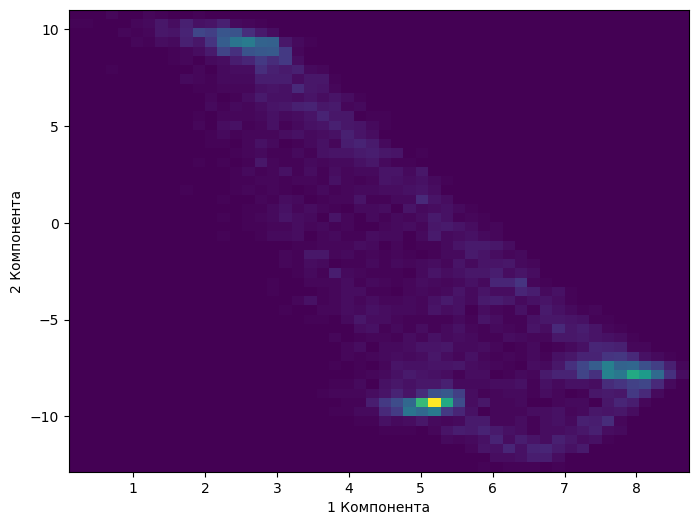

latent_dim = 10
loss: 40.4038960164388


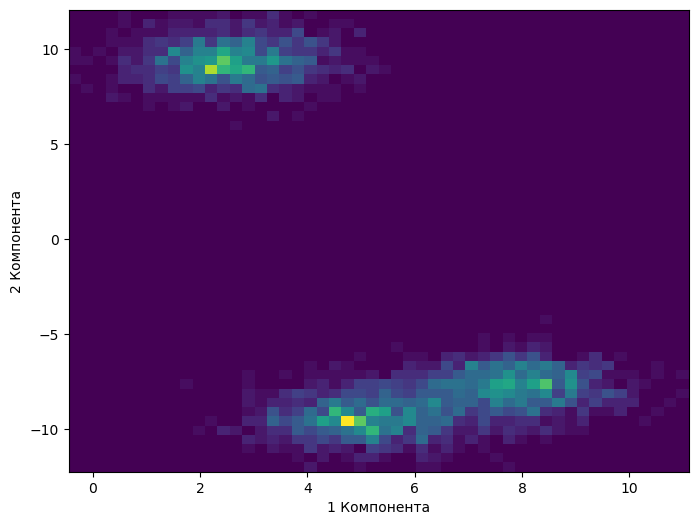

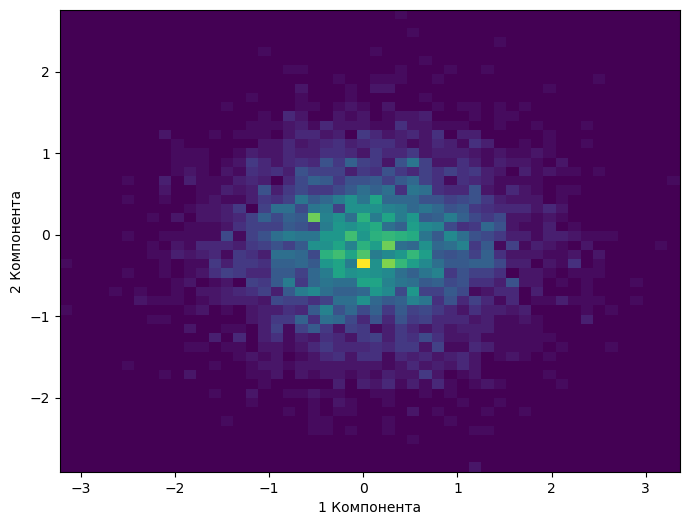

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=34.51154708862305, val_loss=60.102498209635414


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=29.230134963989258, val_loss=59.317813873291016


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=29.594961166381836, val_loss=58.49327147420247


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=29.25484848022461, val_loss=59.02609774780274


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=28.381816864013672, val_loss=58.90798108927409


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=25.85451316833496, val_loss=59.7429453125


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=25.45921516418457, val_loss=58.09132230631511


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=25.575353622436523, val_loss=57.95291915893554


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=28.963369369506836, val_loss=59.26988569132487


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=25.940074920654297, val_loss=58.81847303263346


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=25.06780242919922, val_loss=58.76550239054362


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=23.156579971313477, val_loss=58.12495590209961


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=23.127866744995117, val_loss=58.74458806355794


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=23.76097869873047, val_loss=57.82990889485677


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=25.349199295043945, val_loss=58.03702619425456


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=24.527841567993164, val_loss=60.319781392415365


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=23.500457763671875, val_loss=58.45373996988932


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=23.105009078979492, val_loss=58.23055552164713


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=23.86086082458496, val_loss=58.56507810465495


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=24.357982635498047, val_loss=59.51251681518555


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=24.478303909301758, val_loss=60.05105304972331


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=22.5983943939209, val_loss=59.025011444091795


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=22.09160041809082, val_loss=59.721180836995444


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=22.181962966918945, val_loss=58.54067251586914


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=23.560871124267578, val_loss=59.15310482788086


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=23.28199577331543, val_loss=59.46632613118489


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=23.413497924804688, val_loss=59.17134290568034


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=22.755250930786133, val_loss=59.71481819661458


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=22.160669326782227, val_loss=58.98695905558268


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=22.536354064941406, val_loss=59.06727979532877


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=22.822647094726562, val_loss=59.09593874104818


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=23.564342498779297, val_loss=58.98518145751953


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=22.236055374145508, val_loss=59.12209837849935


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=22.750213623046875, val_loss=59.455928436279294


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=21.308612823486328, val_loss=59.34569451904297


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=22.086946487426758, val_loss=59.45889422607422


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=20.949846267700195, val_loss=58.954998494466146


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=21.372756958007812, val_loss=58.19510608927409


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=21.653186798095703, val_loss=60.40733569335937


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=22.91758918762207, val_loss=59.49137626139323


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=22.77100372314453, val_loss=59.26376372273763


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=22.288131713867188, val_loss=59.00341879272461


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=22.810298919677734, val_loss=59.09479622395833


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=22.299694061279297, val_loss=59.106693471272784


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=22.975175857543945, val_loss=58.59178110758464


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=21.95867347717285, val_loss=59.568778259277344


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=22.3330020904541, val_loss=59.134329132080076


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=22.31986427307129, val_loss=59.467800231933595


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=21.25282096862793, val_loss=58.89094853719075


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=21.83295440673828, val_loss=59.67533180745443


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=21.91224479675293, val_loss=58.98578561401367


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=20.715587615966797, val_loss=59.299643452962236


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=21.942333221435547, val_loss=59.21992884318034


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=20.61705780029297, val_loss=59.06905867513021


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=21.970340728759766, val_loss=59.21859000651042


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=22.030776977539062, val_loss=59.33940149943034


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=21.759647369384766, val_loss=59.35433250935873


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=21.32082176208496, val_loss=59.18712840779622


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=22.471914291381836, val_loss=58.889650685628254


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=22.76561164855957, val_loss=59.223720530192054


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=21.67207145690918, val_loss=59.24797308349609


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=20.641082763671875, val_loss=58.96454364013672


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 58.73092202758789


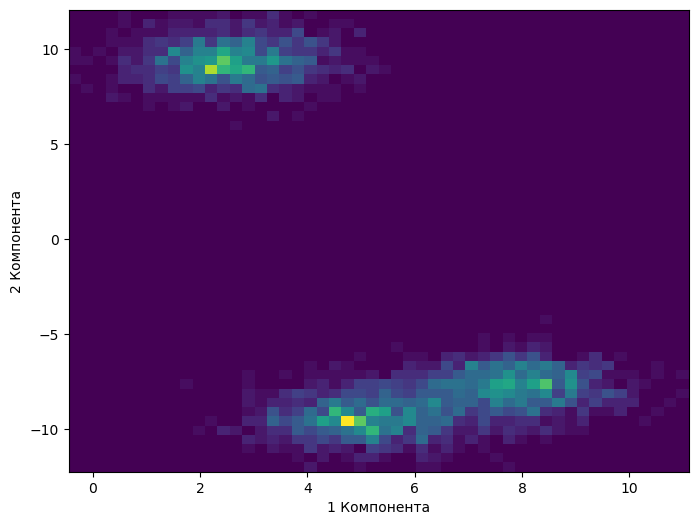

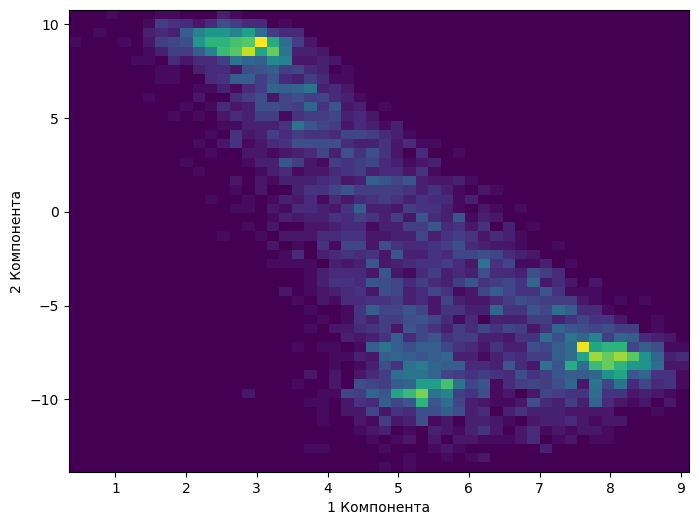

latent_dim = 15
loss: 40.10927887980143


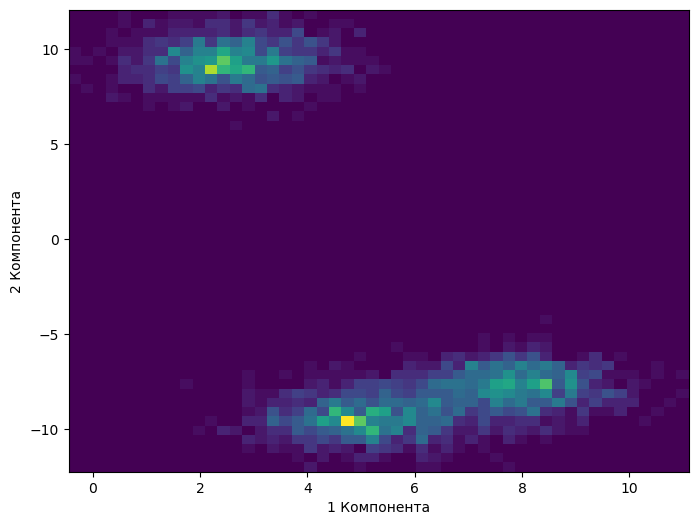

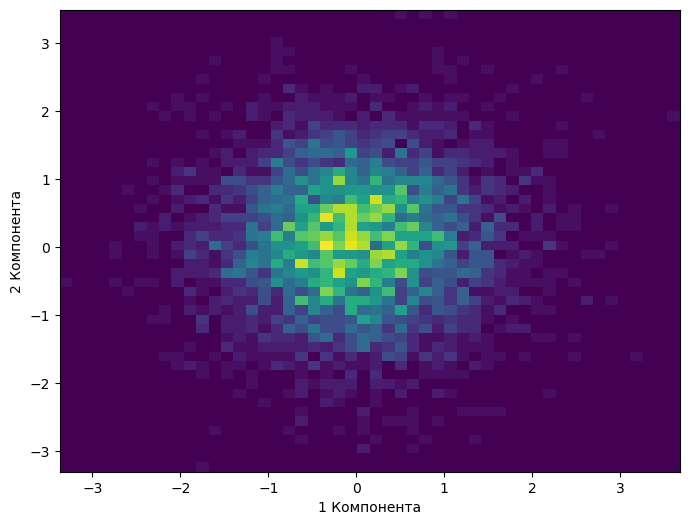

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=35.1825065612793, val_loss=60.54673016357422


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=29.343290328979492, val_loss=58.32760193888346


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=29.45068359375, val_loss=59.5571338297526


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=27.195987701416016, val_loss=59.78924402872721


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=27.530868530273438, val_loss=60.33100557454427


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=26.356107711791992, val_loss=60.20351299031576


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=26.740488052368164, val_loss=59.409671417236325


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=25.418601989746094, val_loss=59.654258534749346


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=25.072057723999023, val_loss=58.34592963663737


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=24.429019927978516, val_loss=58.83715586344401


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=24.75415802001953, val_loss=59.600257873535156


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=24.87145233154297, val_loss=59.53762806193034


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=24.018115997314453, val_loss=59.30813070678711


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=22.830982208251953, val_loss=59.69938419596354


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=23.048229217529297, val_loss=59.83632251993815


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=22.411712646484375, val_loss=58.437999348958336


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=22.835464477539062, val_loss=59.377873931884764


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=22.943267822265625, val_loss=58.13770669555664


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=22.33636474609375, val_loss=60.49172762044271


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=22.906536102294922, val_loss=59.53413803100586


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=23.076372146606445, val_loss=59.03573844401042


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=23.391998291015625, val_loss=58.876399861653645


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=24.735166549682617, val_loss=59.26734762573242


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=21.56583023071289, val_loss=59.43971032714844


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=22.836572647094727, val_loss=59.460707143147786


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=22.41147804260254, val_loss=59.49437163289388


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=22.097078323364258, val_loss=58.578546549479164


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=22.819116592407227, val_loss=59.44163379923503


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=21.952295303344727, val_loss=59.647724802652995


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=22.628345489501953, val_loss=59.3576782430013


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=22.849872589111328, val_loss=59.3392773844401


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=21.722097396850586, val_loss=58.641441345214844


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=23.833145141601562, val_loss=59.37686909993489


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=22.855953216552734, val_loss=59.382278991699216


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=22.245336532592773, val_loss=58.29111129760742


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=21.67084503173828, val_loss=58.95064702351888


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=22.195632934570312, val_loss=59.42416475423177


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=23.079187393188477, val_loss=59.260698476155596


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=22.410083770751953, val_loss=59.00693220011393


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=22.204587936401367, val_loss=59.1442944132487


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=21.641841888427734, val_loss=59.23898331705729


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=22.979402542114258, val_loss=59.264905181884764


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=21.10742950439453, val_loss=59.183686747233075


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=21.66176414489746, val_loss=59.020186828613284


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=21.25455665588379, val_loss=59.52121353149414


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=21.40102767944336, val_loss=59.683165334065755


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=22.130413055419922, val_loss=59.17955008951823


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=20.510976791381836, val_loss=59.2116086324056


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=21.9676456451416, val_loss=58.344443135579425


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=22.204631805419922, val_loss=59.810526326497396


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=21.009435653686523, val_loss=59.156091481526694


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=20.622045516967773, val_loss=59.27198174031575


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=19.835769653320312, val_loss=59.23555425008138


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=21.11619758605957, val_loss=59.52090558878581


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=22.134979248046875, val_loss=59.41876220703125


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=21.370223999023438, val_loss=59.34810217285156


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=20.62057876586914, val_loss=59.447817494710286


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=20.914962768554688, val_loss=59.04046907552083


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=21.44558334350586, val_loss=58.89629470825195


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=21.275928497314453, val_loss=59.503668395996094


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=20.805253982543945, val_loss=59.64920906575521


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=21.15206527709961, val_loss=59.38996422322591


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 59.27851611328125


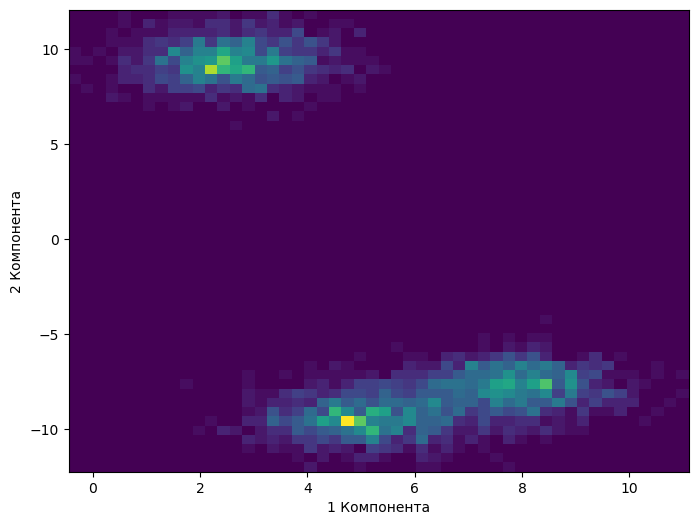

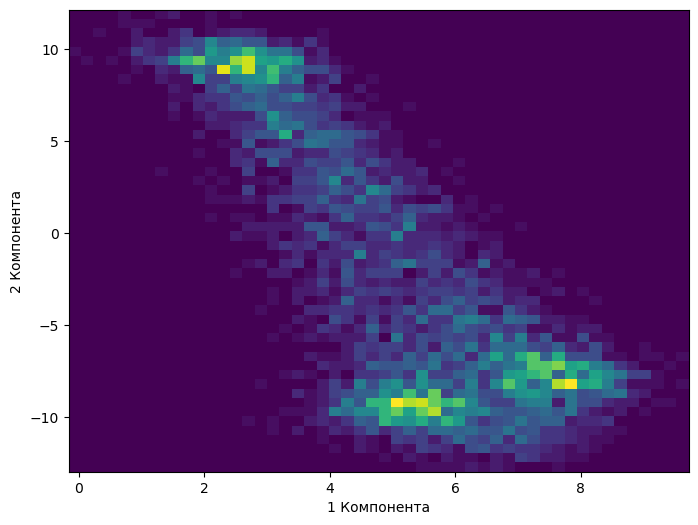

In [252]:
train_dataset, test_dataset = generate_clusters(number_clusters=3, number_samples=5000, vector_size=20)

for latent_dim in latent_dim_list:
    print(f'latent_dim = {latent_dim}')
    
    model = VAE(latent_dim, input_dim=20, hidden_dim=1000)
    model.to(device)
    
    writer = SummaryWriter(log_dir = f'tensorboard_4/latent_dim_{latent_dim}')
    call = callback(writer, test_dataset, loss_function)
    
    check(64, test_dataset, model, loss_function)
    trainer(count_of_epoch=100, 
        batch_size=64, 
        dataset=train_dataset,
        model=model, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)
    check(64, test_dataset, model, loss_function)

Чем больше латность скрытого простаранства, тем лучше результат. 

input_dim = 10
loss: 30.815269373575845


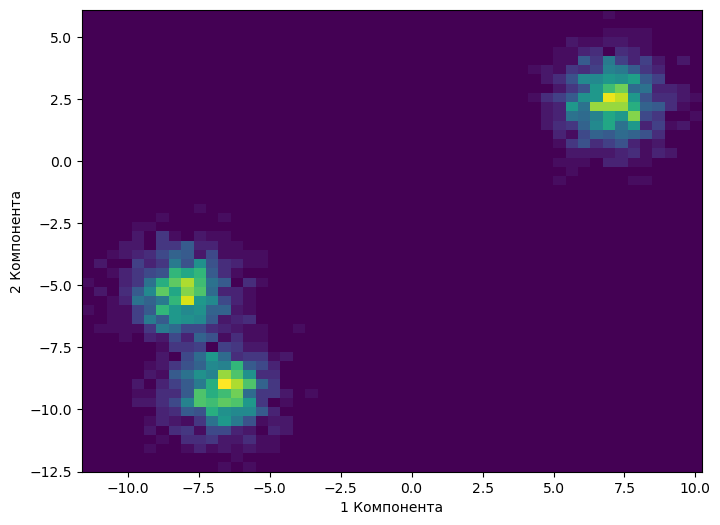

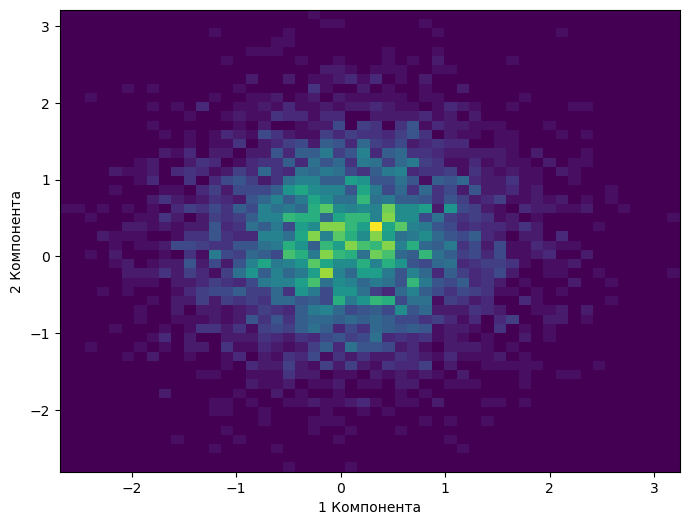

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=16.17950439453125, val_loss=36.94528005981445


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=16.076274871826172, val_loss=37.15537986246745


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=14.931425094604492, val_loss=37.983644134521484


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=14.28794002532959, val_loss=38.88409565226237


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=13.99999713897705, val_loss=39.92453330485026


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=13.006221771240234, val_loss=38.44978630574544


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=12.918558120727539, val_loss=38.71314529418945


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=12.990131378173828, val_loss=39.62371616617838


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=12.499557495117188, val_loss=39.285021575927736


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=13.405774116516113, val_loss=38.941864217122394


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=13.39737606048584, val_loss=39.049073801676435


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=12.307757377624512, val_loss=39.097535471598306


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=13.378334045410156, val_loss=39.57323940022786


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=13.06421184539795, val_loss=39.511626810709636


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=12.343159675598145, val_loss=39.12302628580729


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=12.646279335021973, val_loss=39.90388838704427


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=11.494072914123535, val_loss=38.92629223632812


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=12.381726264953613, val_loss=39.6194716796875


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=12.925153732299805, val_loss=39.557922526041665


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=12.04043197631836, val_loss=40.17220684814453


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=11.793879508972168, val_loss=38.97508467610677


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=12.497979164123535, val_loss=39.33104703776041


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=12.852656364440918, val_loss=39.72448057047526


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=12.026004791259766, val_loss=39.35352056884766


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=11.618297576904297, val_loss=38.7513251953125


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=11.556922912597656, val_loss=39.22285569254557


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=11.891900062561035, val_loss=39.333406748453775


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=10.999086380004883, val_loss=39.78250570678711


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=11.062339782714844, val_loss=38.6300803527832


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=10.724757194519043, val_loss=39.213269185384114


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=11.903938293457031, val_loss=39.07127569580078


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=11.074155807495117, val_loss=39.46784051513672


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=11.437670707702637, val_loss=39.13345688883464


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=11.527491569519043, val_loss=39.54062025960287


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=11.491640090942383, val_loss=39.30386331176758


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=11.695962905883789, val_loss=39.32764335123698


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=11.540130615234375, val_loss=39.15812660725911


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=11.34591293334961, val_loss=39.434845357259114


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=12.011537551879883, val_loss=39.45728888956706


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=11.314976692199707, val_loss=38.95883896891276


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=10.677796363830566, val_loss=39.18066866048177


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=10.833074569702148, val_loss=39.17925966389974


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=11.828470230102539, val_loss=39.13099141438802


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=11.56862735748291, val_loss=39.324382700602214


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=10.664443016052246, val_loss=39.63106342569987


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=13.03046989440918, val_loss=39.98045305379232


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=11.67025089263916, val_loss=39.30385361735026


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=12.037925720214844, val_loss=39.24672948201498


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=11.516654968261719, val_loss=39.530630859375


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=11.394433975219727, val_loss=39.19190297444661


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=10.919017791748047, val_loss=39.24966990152995


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=10.886642456054688, val_loss=39.63038780721028


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=11.38805103302002, val_loss=39.52285303751628


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=10.802806854248047, val_loss=39.323344217936196


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=12.815277099609375, val_loss=39.59117005411784


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=11.529996871948242, val_loss=38.97624723307292


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=11.170112609863281, val_loss=39.48369999186198


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=11.481382369995117, val_loss=39.39824948120117


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=10.963241577148438, val_loss=39.91093123372396


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=11.60888957977295, val_loss=39.84744674682617


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=10.757072448730469, val_loss=39.037452891031904


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=10.94433879852295, val_loss=39.59092458089193


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 39.61056419881185


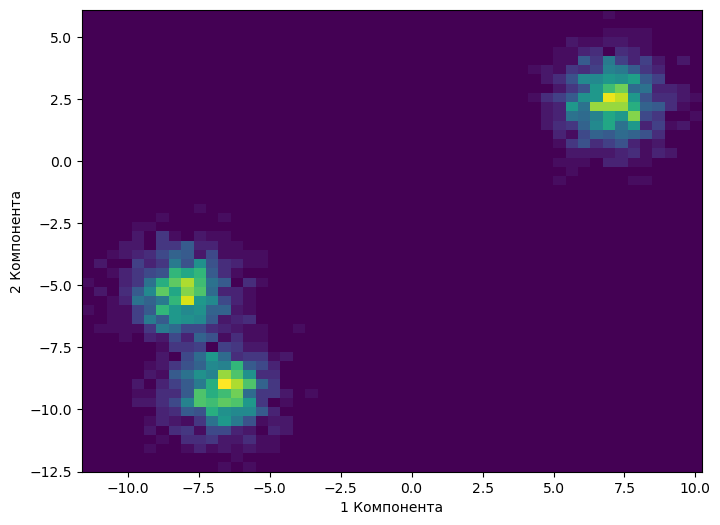

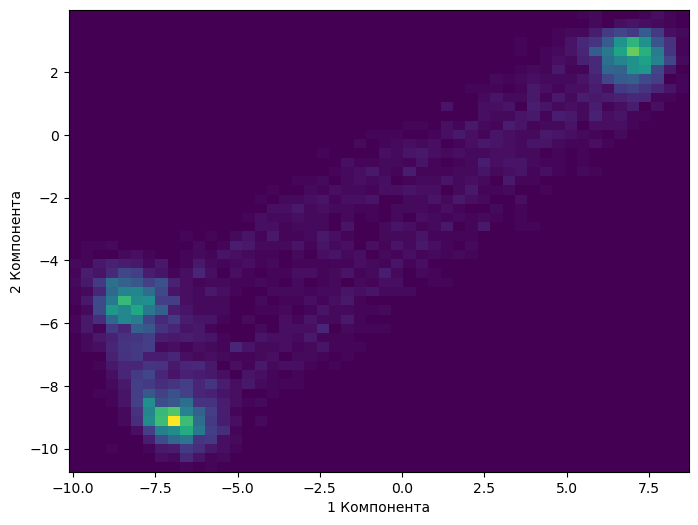

input_dim = 20
loss: 37.33963670857747


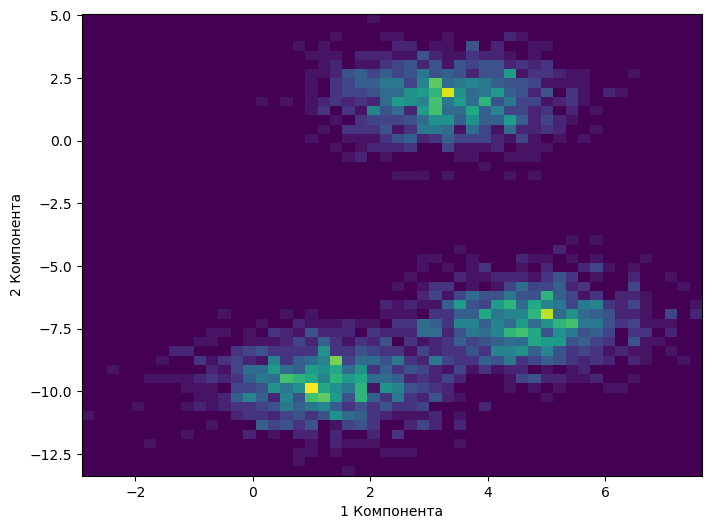

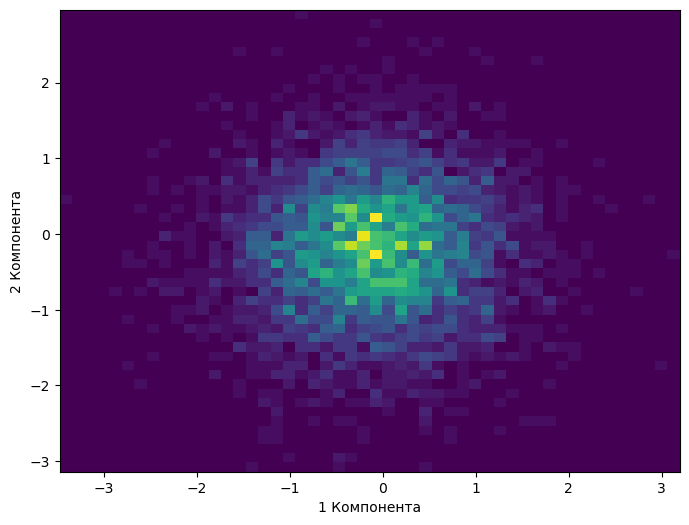

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=30.0886287689209, val_loss=46.72416128540039


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=28.593515396118164, val_loss=47.139888448079425


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=27.57085418701172, val_loss=46.49234379069011


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=26.92483139038086, val_loss=48.72087424723307


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=26.004304885864258, val_loss=47.27222436523437


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=24.560758590698242, val_loss=47.736004547119144


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=24.557100296020508, val_loss=46.88116562906901


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=25.683570861816406, val_loss=47.945239064534505


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=25.344974517822266, val_loss=48.65494416300456


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=25.733762741088867, val_loss=48.00741456095378


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=24.6486873626709, val_loss=47.874904337565106


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=25.89674186706543, val_loss=47.03550791422526


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=23.553041458129883, val_loss=47.78149760945638


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=24.099340438842773, val_loss=46.73638197835287


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=24.246978759765625, val_loss=47.205759063720706


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=24.573827743530273, val_loss=48.180469431559246


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=23.834613800048828, val_loss=47.78295198567708


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=22.972145080566406, val_loss=48.174547322591145


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=24.575756072998047, val_loss=46.94433245849609


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=24.796443939208984, val_loss=47.380066009521485


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=23.948759078979492, val_loss=47.819793324788414


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=23.63620376586914, val_loss=47.89537785847982


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=22.74526023864746, val_loss=47.28655791219076


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=23.97161865234375, val_loss=47.31198247273763


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=22.77507209777832, val_loss=47.647544545491535


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=24.856426239013672, val_loss=47.39090443929037


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=22.742212295532227, val_loss=47.45716931152344


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=23.028057098388672, val_loss=47.92498538208008


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=21.396841049194336, val_loss=47.21612653605143


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=22.533653259277344, val_loss=47.34356000773112


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=23.217296600341797, val_loss=47.1280983988444


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=22.377103805541992, val_loss=47.70084455362956


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=22.112749099731445, val_loss=47.048360463460284


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=22.178428649902344, val_loss=47.41059848022461


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=23.010770797729492, val_loss=47.4034572652181


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=22.92896270751953, val_loss=47.49148405965169


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=22.39943504333496, val_loss=47.589110982259115


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=22.345853805541992, val_loss=47.170395731608075


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=21.1573429107666, val_loss=47.632313262939455


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=21.691137313842773, val_loss=47.62847885131836


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=21.68890953063965, val_loss=47.568470235188805


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=21.43572425842285, val_loss=47.60483290608724


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=22.42954444885254, val_loss=47.98280530802409


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=23.53025245666504, val_loss=47.08364203898112


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=22.155025482177734, val_loss=47.61767832438151


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=23.13792610168457, val_loss=47.29620911661784


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=23.351028442382812, val_loss=47.47798385620117


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=22.9982967376709, val_loss=47.59893202718099


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=22.723514556884766, val_loss=47.419932383219404


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=22.158491134643555, val_loss=47.520556833902994


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=20.911376953125, val_loss=47.28612708536784


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=21.038612365722656, val_loss=47.11271598307292


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=23.908979415893555, val_loss=47.4453771870931


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=20.798446655273438, val_loss=47.25237337239583


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=22.7176456451416, val_loss=47.14586024983724


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=22.440109252929688, val_loss=47.65420572916667


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=21.773113250732422, val_loss=47.32418690999349


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=22.41572380065918, val_loss=47.46318936157227


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=21.01622772216797, val_loss=47.74016638183594


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=22.15057373046875, val_loss=47.39803966267904


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=21.31725311279297, val_loss=48.05083539835612


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=20.652679443359375, val_loss=47.2272980855306


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 47.478344665527345


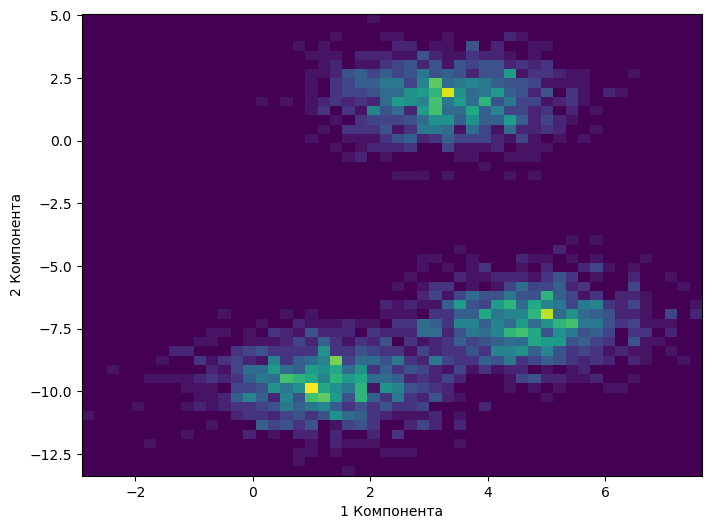

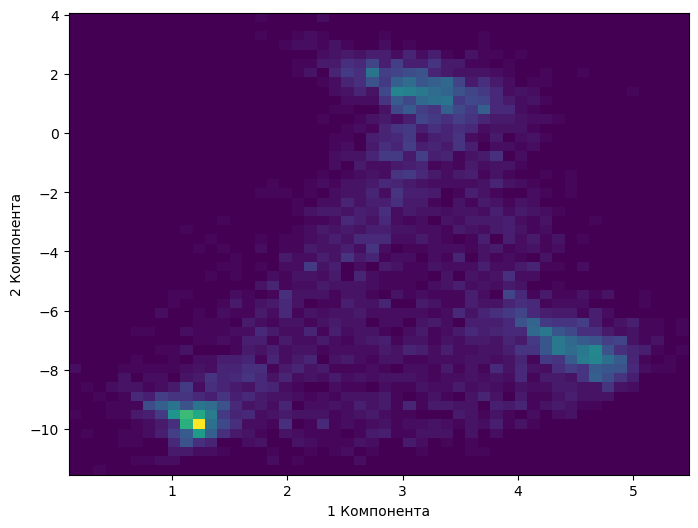

input_dim = 30
loss: 39.88110664876302


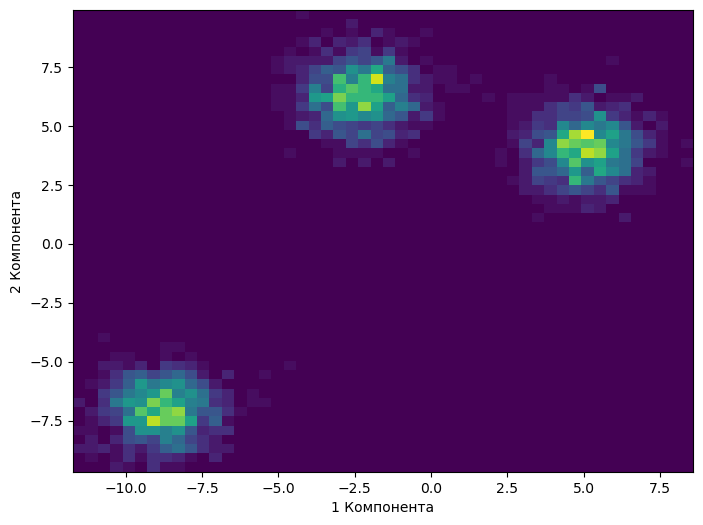

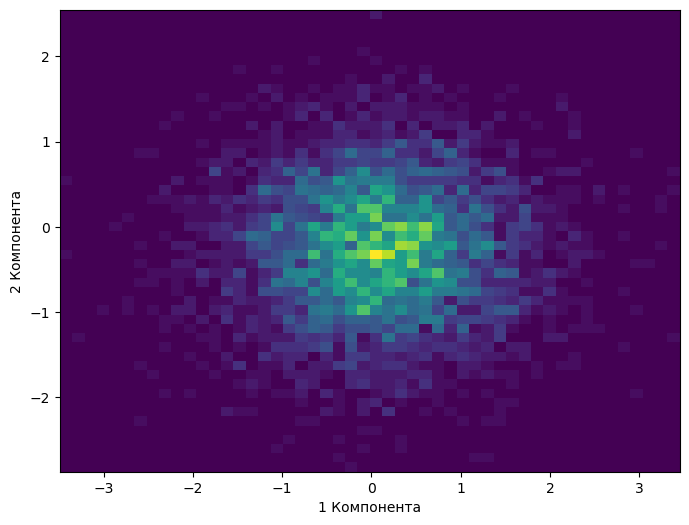

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=43.0452880859375, val_loss=57.47860399373372


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=38.78696060180664, val_loss=57.07393756103516


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=37.10650634765625, val_loss=57.15284458414713


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=38.77732467651367, val_loss=57.76063921101888


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=35.78983688354492, val_loss=58.028272298177086


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=38.75817108154297, val_loss=57.03525883992513


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=36.158531188964844, val_loss=58.44150493367513


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=34.948890686035156, val_loss=56.65329988606771


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=35.82059097290039, val_loss=58.760358266194665


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=36.581302642822266, val_loss=56.42119873046875


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=35.355445861816406, val_loss=57.314196767171225


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=35.39407730102539, val_loss=56.888218719482424


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=35.52547073364258, val_loss=57.56506631469727


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=34.37696838378906, val_loss=57.052552235921226


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=33.922760009765625, val_loss=56.981694854736325


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=33.766502380371094, val_loss=56.7996267191569


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=35.470115661621094, val_loss=57.33092524210612


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=33.87346649169922, val_loss=56.95629539998372


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=33.981781005859375, val_loss=57.92956430053711


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=34.75423812866211, val_loss=57.05048756917318


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=35.60324478149414, val_loss=56.79617590332031


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=32.41580581665039, val_loss=57.16358544921875


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=34.70921325683594, val_loss=56.98772305297852


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=34.445465087890625, val_loss=56.99115102132161


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=34.19856262207031, val_loss=56.77096294148763


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=34.05915832519531, val_loss=57.0629538675944


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=33.63889694213867, val_loss=57.58999478149414


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=32.785125732421875, val_loss=57.09502894083659


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=32.179115295410156, val_loss=57.63923325602214


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=31.98670196533203, val_loss=57.24806119791667


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=33.1782112121582, val_loss=56.91626517740885


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=34.23097229003906, val_loss=57.33219916788737


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=32.003326416015625, val_loss=57.05630647786458


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=33.34397888183594, val_loss=57.135439829508464


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=35.160003662109375, val_loss=57.146159983317055


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=36.41605758666992, val_loss=57.12624653116862


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=33.064674377441406, val_loss=57.44961506144206


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=32.11581039428711, val_loss=57.118476399739585


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=33.24849319458008, val_loss=56.38383048502604


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=32.055606842041016, val_loss=57.44388651529948


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=32.47712707519531, val_loss=57.463423380533854


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=34.18215560913086, val_loss=56.86302261352539


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=32.43231964111328, val_loss=57.01761818440755


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=31.409446716308594, val_loss=57.3796530863444


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=34.124996185302734, val_loss=56.623973490397134


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=34.90007781982422, val_loss=57.709103637695314


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=36.37667465209961, val_loss=57.00193375651042


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=30.698381423950195, val_loss=56.966344045003254


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=31.947723388671875, val_loss=57.194891469319664


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=32.43111038208008, val_loss=57.10718506876628


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=33.44381332397461, val_loss=56.73963697306315


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=31.52552032470703, val_loss=57.34164216105143


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=33.40233612060547, val_loss=57.137909311930336


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=32.90234375, val_loss=57.24623721313476


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=32.1544189453125, val_loss=57.00502035522461


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=32.95451354980469, val_loss=56.81048577880859


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=31.85405731201172, val_loss=56.88076014200846


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=32.435829162597656, val_loss=56.95777778116862


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=32.41999435424805, val_loss=57.19039492797852


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=32.9673957824707, val_loss=56.689278513590494


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=31.803081512451172, val_loss=56.89808201090495


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=33.42095947265625, val_loss=56.923230865478516


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 56.784588857014974


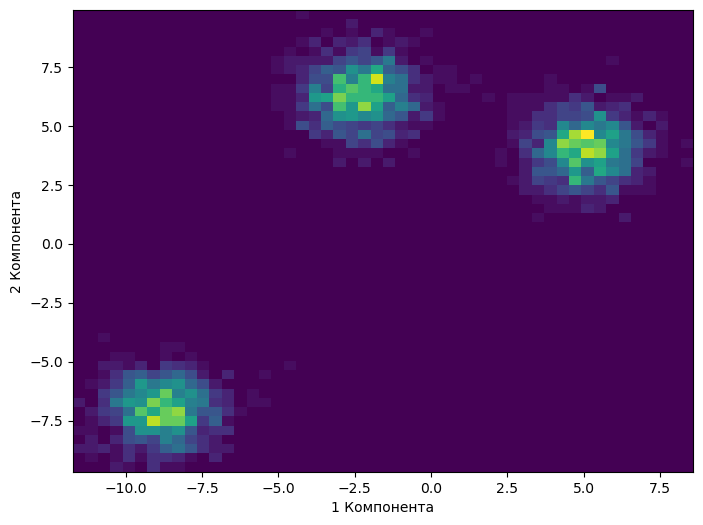

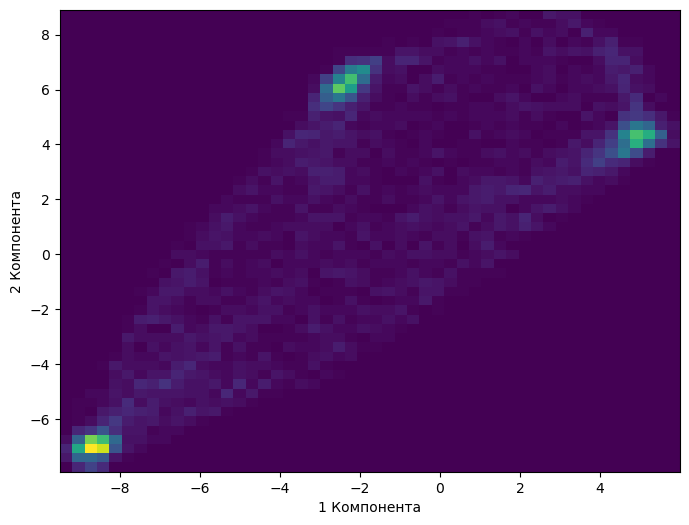

In [254]:
for input_dim in input_dim_list:
    print(f'input_dim = {input_dim}')
    
    train_dataset, test_dataset = generate_clusters(number_clusters=3, number_samples=5000, vector_size=input_dim)
    
    model = VAE(latent_dim=5, input_dim=input_dim, hidden_dim=1000)
    model.to(device)
    
    writer = SummaryWriter(log_dir = f'tensorboard_4/input_dim_{input_dim}')
    call = callback(writer, test_dataset, loss_function)
    
    check(64, test_dataset, model, loss_function)
    trainer(count_of_epoch=100, 
        batch_size=64, 
        dataset=train_dataset,
        model=model, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)
    check(64, test_dataset, model, loss_function)

Были получены неплохие результаты, но достаточно неточные.

relationship = 0.5
loss: 41.015327178955076


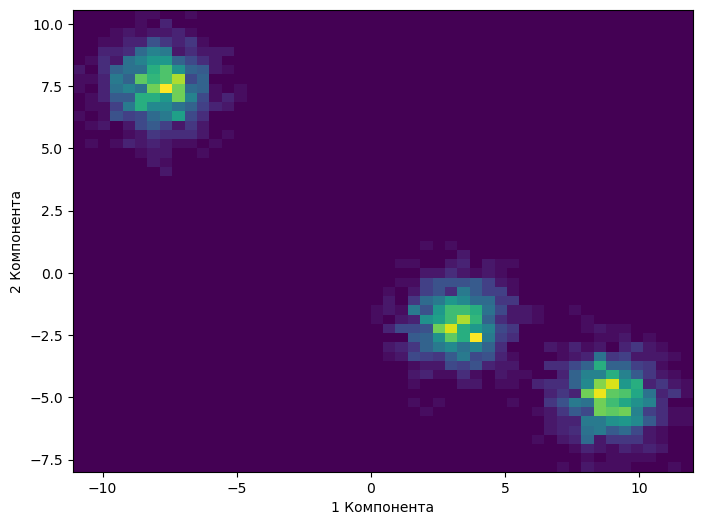

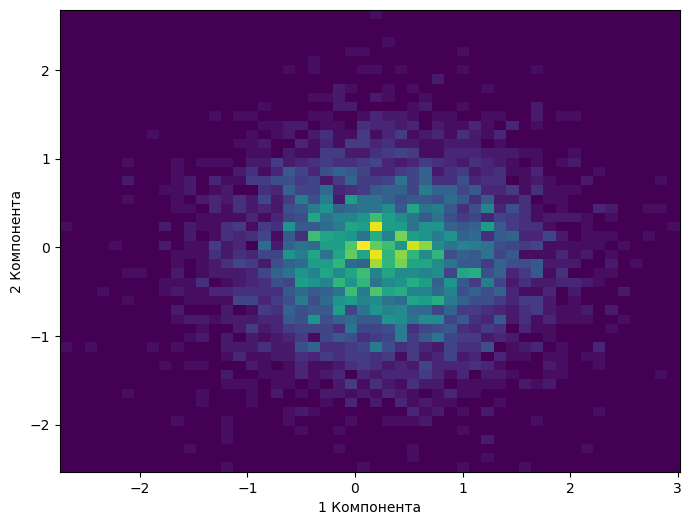

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=48.833518981933594, val_loss=57.93763198852539


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=44.0050163269043, val_loss=58.43355065917969


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=39.10936737060547, val_loss=60.737094716389976


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=38.30115509033203, val_loss=60.964934356689454


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=36.1345329284668, val_loss=60.678852793375654


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=35.882232666015625, val_loss=59.395080841064456


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=35.70836639404297, val_loss=60.16525088500977


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=35.69275665283203, val_loss=59.839958089192706


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=35.170806884765625, val_loss=60.13495115152995


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=34.21220397949219, val_loss=58.9169284769694


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=35.33148956298828, val_loss=60.1737692565918


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=36.811378479003906, val_loss=60.15537984212239


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=35.77494430541992, val_loss=60.18510491943359


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=34.60858154296875, val_loss=60.67274022420247


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=35.61396789550781, val_loss=59.85918779500326


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=33.56810760498047, val_loss=59.07514417521159


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=35.133018493652344, val_loss=60.01167356363932


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=32.99124526977539, val_loss=60.197506571451825


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=34.23314666748047, val_loss=59.80158304850261


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=33.05459213256836, val_loss=60.259148498535154


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=32.31429672241211, val_loss=59.34925223795573


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=32.871055603027344, val_loss=59.461387878417966


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=33.04003143310547, val_loss=60.10502998860677


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=32.32701110839844, val_loss=59.77908554077148


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=32.31660079956055, val_loss=59.98994302368164


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=32.157752990722656, val_loss=60.47734187825521


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=34.173927307128906, val_loss=59.87156153361003


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=32.907798767089844, val_loss=59.947682556152344


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=32.56447982788086, val_loss=59.899415364583334


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=32.86770248413086, val_loss=60.643121724446615


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=33.480751037597656, val_loss=60.11522325642903


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=33.185455322265625, val_loss=60.4614054667155


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=32.20104217529297, val_loss=59.953250508626304


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=32.695579528808594, val_loss=60.03645090738932


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=32.444862365722656, val_loss=60.76247012329102


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=32.50807189941406, val_loss=60.576186045328775


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=32.82421875, val_loss=59.97715493774414


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=33.204925537109375, val_loss=59.23867377726237


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=31.182424545288086, val_loss=59.53488844807943


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=32.45098876953125, val_loss=60.11135066731771


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=33.27985382080078, val_loss=60.09148424275716


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=31.839662551879883, val_loss=60.59239163208008


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=31.410831451416016, val_loss=59.9561200764974


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=31.255128860473633, val_loss=61.15134913126628


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=33.319244384765625, val_loss=60.2504985555013


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=33.209476470947266, val_loss=60.24515421549479


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=31.820112228393555, val_loss=60.429511810302735


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=31.65223503112793, val_loss=60.553432810465495


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=29.74810028076172, val_loss=60.41410990397135


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=30.929040908813477, val_loss=59.86476138305664


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=31.67382049560547, val_loss=59.701204783121746


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=31.813077926635742, val_loss=59.83633026123047


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=33.068336486816406, val_loss=59.99427369181315


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=31.28274917602539, val_loss=60.10131418863932


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=32.039852142333984, val_loss=59.97302734375


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=32.167999267578125, val_loss=59.6818503519694


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=30.978727340698242, val_loss=60.501680613199866


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=31.810396194458008, val_loss=59.832614044189455


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=32.74567794799805, val_loss=60.34292932128906


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=31.855361938476562, val_loss=60.28808861287435


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=32.58632278442383, val_loss=59.57542280069987


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=32.251869201660156, val_loss=60.23283464558919


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 60.25489892578125


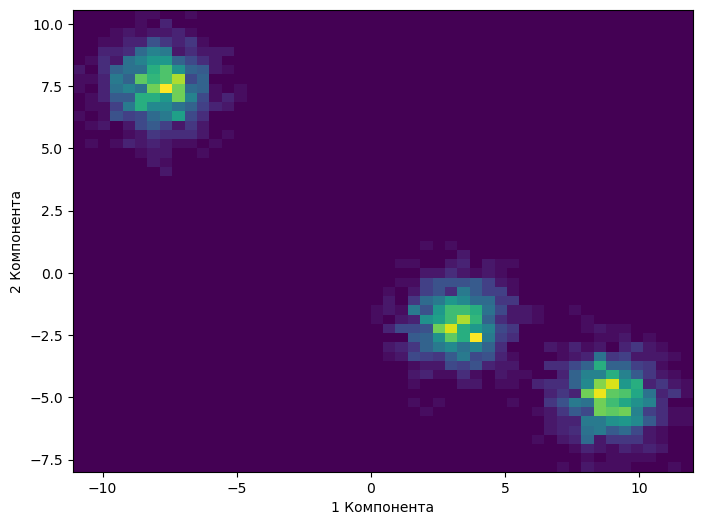

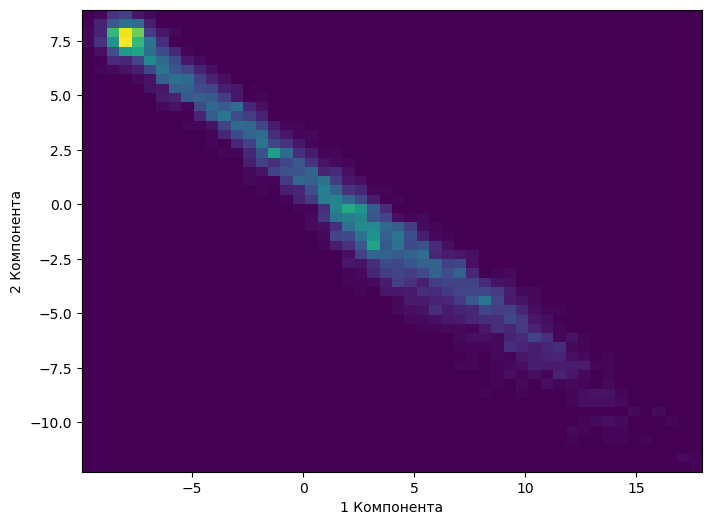

relationship = 1
loss: 41.12999289957682


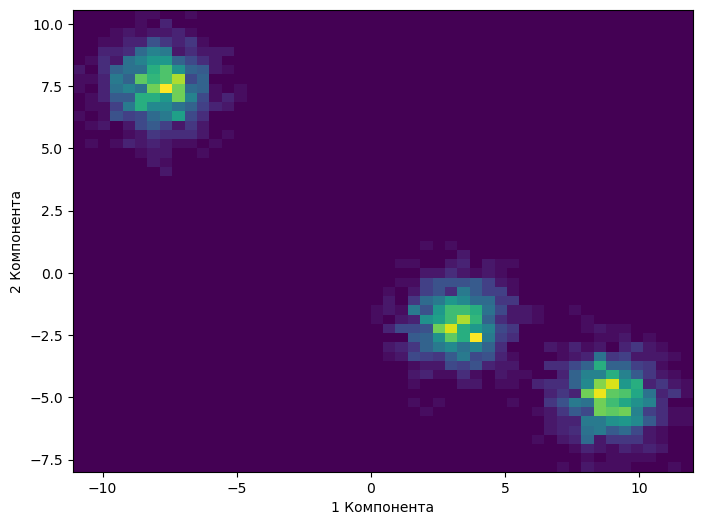

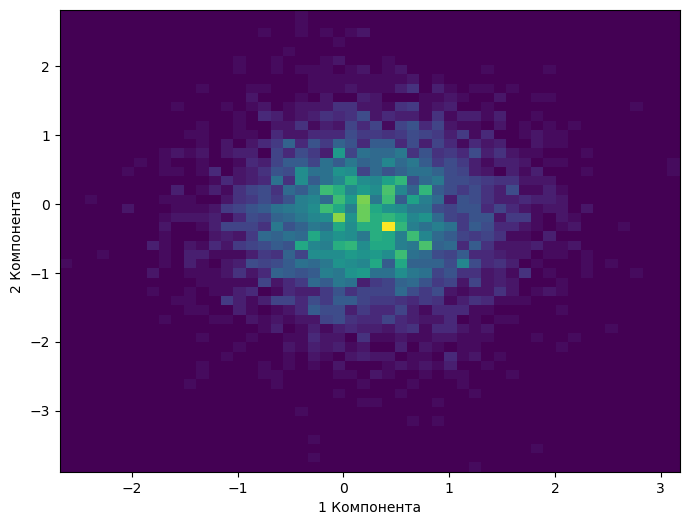

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=54.45683288574219, val_loss=59.54891932169596


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=47.23992156982422, val_loss=59.010260823567705


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=41.987342834472656, val_loss=59.4659582824707


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=41.48526382446289, val_loss=60.12287653605143


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=38.231178283691406, val_loss=60.95666295369466


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=35.72500991821289, val_loss=59.85467294311523


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=35.601558685302734, val_loss=59.48809090169271


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=38.119384765625, val_loss=61.14384696451823


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=33.557708740234375, val_loss=59.46912392171224


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=33.735538482666016, val_loss=60.38755915323893


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=33.05297088623047, val_loss=61.490487813313806


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=33.187591552734375, val_loss=60.22346266682943


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=31.95304298400879, val_loss=60.60151397705078


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=32.65277862548828, val_loss=61.66270793660482


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=31.516590118408203, val_loss=60.45128839111328


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=32.407833099365234, val_loss=59.95344381713867


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=32.11391830444336, val_loss=60.00890704345703


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=30.978416442871094, val_loss=60.47173951212565


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=31.364521026611328, val_loss=60.307033569335935


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=30.898820877075195, val_loss=60.44370133463541


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=34.25132369995117, val_loss=60.18540809122722


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=30.52837371826172, val_loss=61.205131174723306


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=32.28300094604492, val_loss=60.6189464823405


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=31.271509170532227, val_loss=60.77069149780274


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=32.10552978515625, val_loss=60.616662709554035


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=31.506837844848633, val_loss=59.98550961303711


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=31.88844871520996, val_loss=59.742514373779294


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=30.9768009185791, val_loss=60.44064686075846


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=31.84653091430664, val_loss=60.897234436035156


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=31.19997215270996, val_loss=60.25781391398112


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=32.2826042175293, val_loss=60.50671057128906


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=31.427701950073242, val_loss=60.591724385579425


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=32.21297836303711, val_loss=59.95069155883789


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=31.725914001464844, val_loss=60.803302225748695


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=31.479543685913086, val_loss=60.03710996500651


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=30.845855712890625, val_loss=60.04695087687175


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=31.843706130981445, val_loss=61.20647815958659


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=31.29416847229004, val_loss=60.64189306640625


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=31.45060157775879, val_loss=60.11374931844075


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=30.99750328063965, val_loss=61.00594756062826


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=30.913217544555664, val_loss=60.0246223042806


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=31.763347625732422, val_loss=60.43374578857422


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=30.54377555847168, val_loss=60.50359134928385


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=30.416419982910156, val_loss=60.19953695678711


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=31.49178695678711, val_loss=60.215644307454426


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=30.852909088134766, val_loss=60.17466701253255


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=30.735607147216797, val_loss=60.52983597819011


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=31.314918518066406, val_loss=60.09165687052409


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=31.458812713623047, val_loss=60.071821685791015


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=31.203336715698242, val_loss=59.84851471964518


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=32.04199981689453, val_loss=60.44053293863932


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=30.171794891357422, val_loss=60.468017923990885


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=31.47993278503418, val_loss=59.7598620707194


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=30.98624610900879, val_loss=60.77860030110677


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=31.023569107055664, val_loss=60.13338045247396


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=30.769092559814453, val_loss=60.046772837320965


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=29.989429473876953, val_loss=60.40913195800781


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=30.505996704101562, val_loss=60.95430556233724


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=30.702220916748047, val_loss=60.44452895100911


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=30.338905334472656, val_loss=60.442162882486976


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=31.289642333984375, val_loss=60.259654256184895


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=31.035179138183594, val_loss=60.36941976928711


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 60.23386492919922


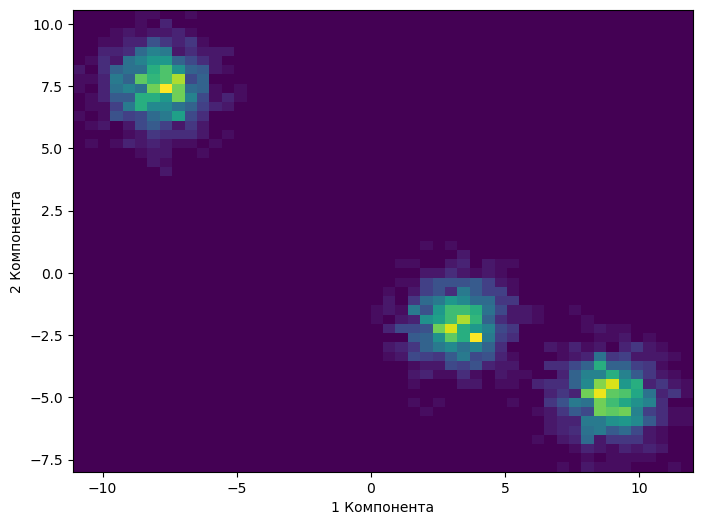

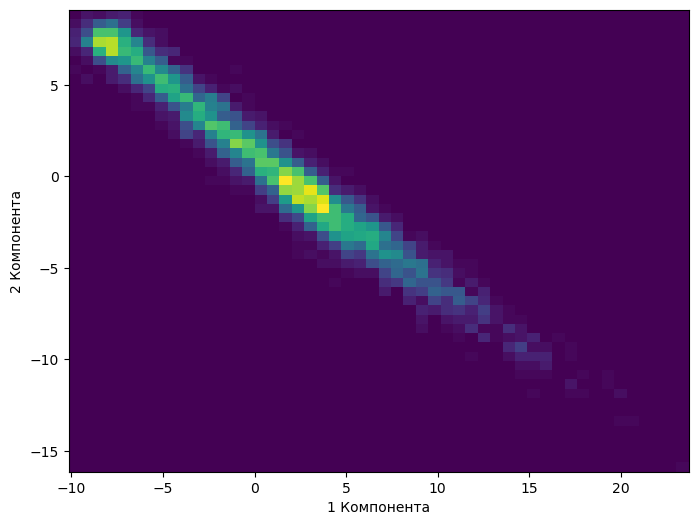

relationship = 2
loss: 41.054047780354814


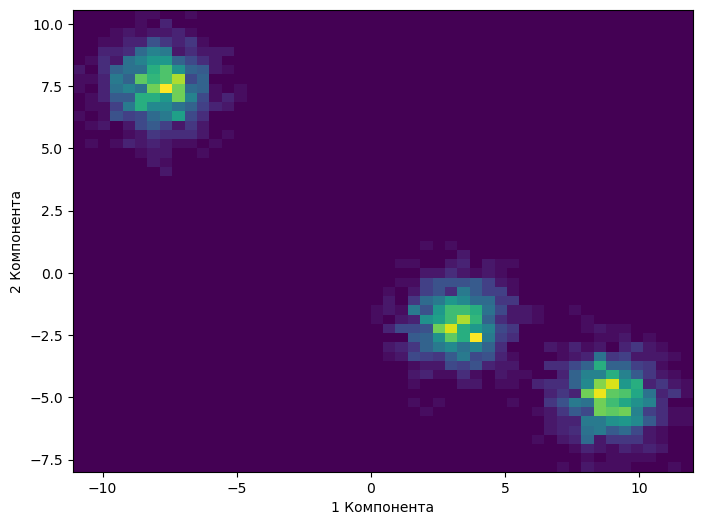

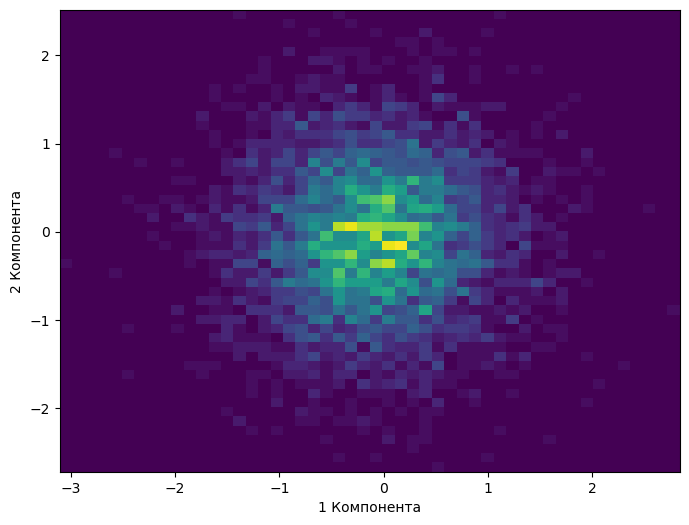

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=63.42857360839844, val_loss=59.762090169270834


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=54.48922348022461, val_loss=60.19150674438477


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=48.70968246459961, val_loss=57.95415333048503


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=42.66240692138672, val_loss=59.852299509684244


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=38.73413848876953, val_loss=59.2520476582845


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=38.01070022583008, val_loss=60.35564242553711


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=36.927024841308594, val_loss=61.83466729736328


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=36.39402770996094, val_loss=59.63916828409831


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=37.01038360595703, val_loss=59.117027526855466


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=36.733245849609375, val_loss=61.25059779866537


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=35.04969787597656, val_loss=61.176532196044924


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=36.62385559082031, val_loss=60.05428650919596


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=35.344703674316406, val_loss=60.03186251831055


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=34.00617218017578, val_loss=60.58639112345378


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=33.25244140625, val_loss=59.651043670654296


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=32.87647247314453, val_loss=59.87876342773438


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=33.3177490234375, val_loss=60.406532165527345


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=33.340206146240234, val_loss=59.885275024414064


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=32.235633850097656, val_loss=60.32495635986328


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=32.133888244628906, val_loss=60.8539145304362


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=31.80626678466797, val_loss=60.49729916381836


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=31.73134422302246, val_loss=60.10733794148763


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=32.00955581665039, val_loss=60.1814775797526


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=30.929298400878906, val_loss=60.50851816813151


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=32.09797286987305, val_loss=60.94067515055338


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=31.88272476196289, val_loss=59.960609252929686


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=31.94454002380371, val_loss=59.97968651326497


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=30.948148727416992, val_loss=60.9061762898763


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=32.03082275390625, val_loss=60.273088358561196


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=32.09919357299805, val_loss=59.61369447835286


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=31.839527130126953, val_loss=60.34068835449219


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=32.406856536865234, val_loss=59.98790892537435


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=31.137563705444336, val_loss=60.935226318359376


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=32.39826202392578, val_loss=60.40868565877279


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=31.95589828491211, val_loss=60.64395194498698


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=31.973310470581055, val_loss=60.965108510335284


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=31.344547271728516, val_loss=59.627153310139974


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=31.92901611328125, val_loss=60.51187812296549


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=32.304203033447266, val_loss=60.47922085571289


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=31.15286636352539, val_loss=60.19093105061849


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=31.62287712097168, val_loss=60.10147279866536


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=31.320720672607422, val_loss=61.30550691731771


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=31.366344451904297, val_loss=60.41334530639649


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=31.46509552001953, val_loss=60.537593475341794


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=32.18381881713867, val_loss=60.288339955647785


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=31.035926818847656, val_loss=60.703939697265625


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=31.646278381347656, val_loss=60.48843123372396


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=30.761972427368164, val_loss=60.124084503173826


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=31.67330551147461, val_loss=60.299970723470054


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=32.09844207763672, val_loss=61.44884522501628


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=30.509469985961914, val_loss=60.612730143229165


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=31.684890747070312, val_loss=60.66714999389649


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=30.92538833618164, val_loss=59.89062379964193


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=32.037193298339844, val_loss=60.91654580688476


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=30.578989028930664, val_loss=59.83866643269857


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=30.479787826538086, val_loss=59.94385641479492


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=29.748022079467773, val_loss=59.94092521158854


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=30.536916732788086, val_loss=60.55142736816406


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=31.158737182617188, val_loss=59.489271341959636


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=30.950422286987305, val_loss=60.32883584594727


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=31.12916374206543, val_loss=60.34562440999349


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=29.96063232421875, val_loss=60.79008028157552


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 59.470245493570964


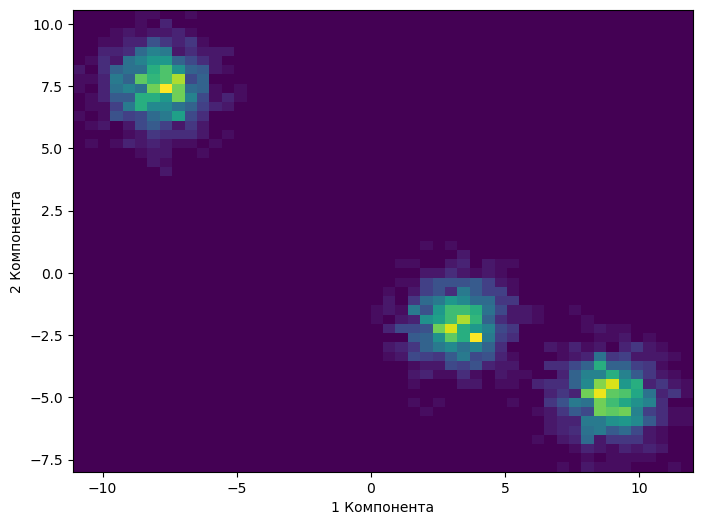

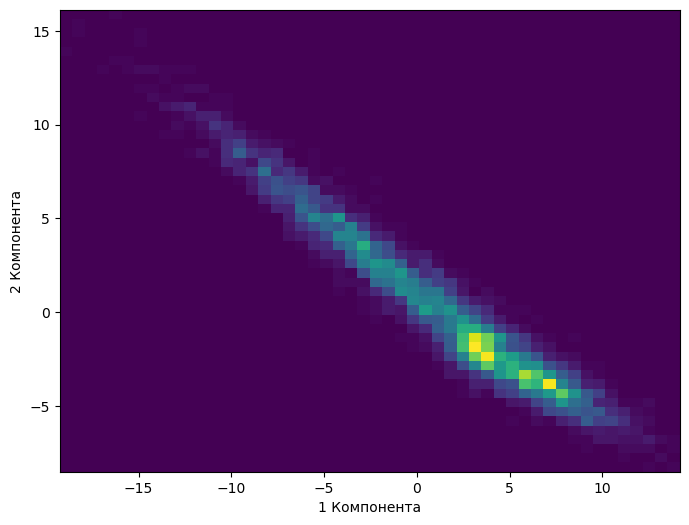

In [257]:
vector_size = 30
train_dataset, test_dataset = generate_clusters(number_clusters=3, number_samples=5000, vector_size=vector_size)

for relationship in relationship_list:
    print(f'relationship = {relationship}')
    
    model = VAE(latent_dim=int(relationship * vector_size), input_dim=30, hidden_dim=1000)
    model.to(device)
    
    writer = SummaryWriter(log_dir = f'tensorboard_4/relationship_{relationship}')
    call = callback(writer, test_dataset, loss_function)
    
    check(64, test_dataset, model, loss_function)
    trainer(count_of_epoch=100, 
        batch_size=64, 
        dataset=train_dataset,
        model=model, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)
    check(64, test_dataset, model, loss_function)

Результат хороший, когда размерность латантного пространства не очень большая близка к размерности входного.

hidden_dim = 300
loss: 33.670955729166664


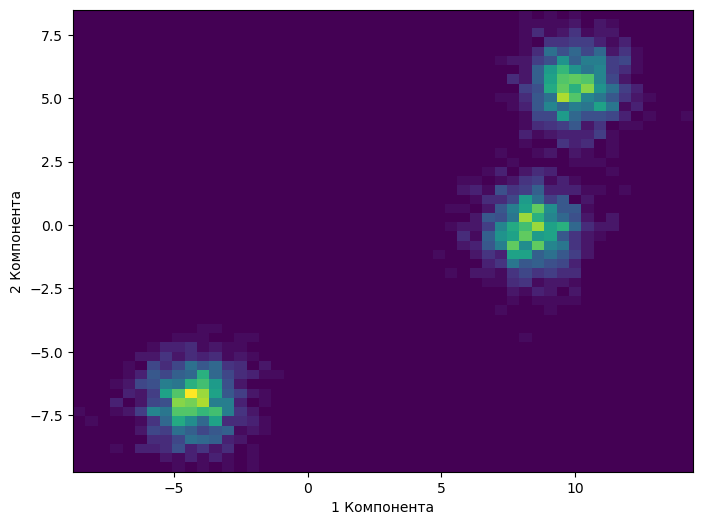

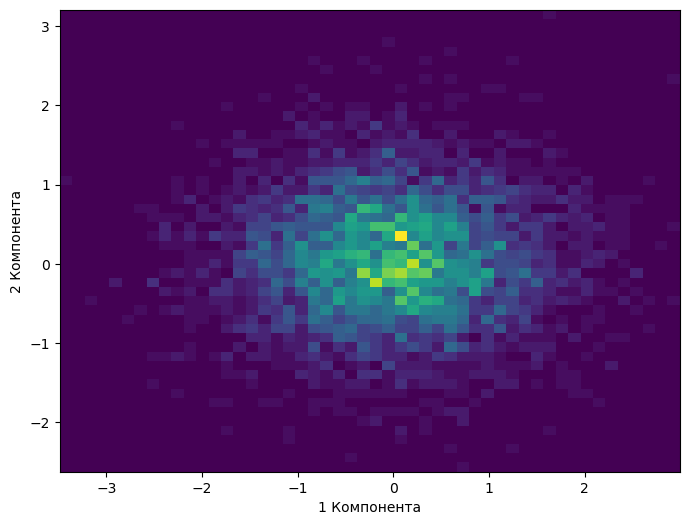

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=57.45937728881836, val_loss=51.361547485351565


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=52.18576431274414, val_loss=52.110529337565104


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=49.51124954223633, val_loss=52.97575081380209


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=44.092777252197266, val_loss=51.82590910847982


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=42.023681640625, val_loss=52.79664735921224


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=38.5625114440918, val_loss=51.67120235188802


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=37.28356170654297, val_loss=51.78836038208008


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=37.14381408691406, val_loss=52.61432609049479


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=33.978660583496094, val_loss=52.1591181640625


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=32.286865234375, val_loss=52.38933686319987


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=33.489532470703125, val_loss=52.91713565063476


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=32.31961441040039, val_loss=52.10499408976237


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=32.71714782714844, val_loss=51.718240417480466


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=31.917543411254883, val_loss=51.88917379760742


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=32.09593200683594, val_loss=51.1921941019694


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=30.973390579223633, val_loss=52.27991555786133


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=32.195125579833984, val_loss=52.13519169108073


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=31.872377395629883, val_loss=52.66380074055989


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=32.79738998413086, val_loss=52.236579864501955


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=32.01484298706055, val_loss=52.336051534016924


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=30.78987693786621, val_loss=51.842855346679684


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=31.19667625427246, val_loss=52.47489841715495


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=30.516387939453125, val_loss=51.92719750976563


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=31.181344985961914, val_loss=51.877231129964194


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=30.141698837280273, val_loss=52.30005035400391


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=31.49590301513672, val_loss=52.16684076944987


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=31.642070770263672, val_loss=51.95312240600586


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=30.64472770690918, val_loss=53.031118672688805


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=30.695037841796875, val_loss=52.670658477783206


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=31.907981872558594, val_loss=52.301452911376956


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=32.7122802734375, val_loss=51.66845526123047


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=32.37346267700195, val_loss=52.856515909830726


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=31.60959243774414, val_loss=51.90534200032552


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=30.572189331054688, val_loss=52.43615076700846


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=30.891027450561523, val_loss=52.078028513590496


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=31.33344078063965, val_loss=52.5812302347819


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=32.850852966308594, val_loss=52.78586289469401


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=31.402795791625977, val_loss=51.97566068522136


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=30.047758102416992, val_loss=52.445883433024086


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=29.619407653808594, val_loss=52.65060405476888


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=30.622180938720703, val_loss=52.51939385986328


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=30.340152740478516, val_loss=52.52561530558268


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=30.40994644165039, val_loss=52.588032745361325


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=30.83414649963379, val_loss=52.36140739949544


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=30.337356567382812, val_loss=52.11824719238281


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=30.07636833190918, val_loss=52.82088838704427


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=30.520904541015625, val_loss=51.948449106852216


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=31.174911499023438, val_loss=52.43644904581706


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=31.760202407836914, val_loss=52.88129457600911


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=30.98841667175293, val_loss=52.573378173828125


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=30.709325790405273, val_loss=52.90952076212565


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=29.850465774536133, val_loss=53.01179341634115


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=30.35382080078125, val_loss=52.68422611490885


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=30.269268035888672, val_loss=52.62370745849609


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=30.777812957763672, val_loss=52.355164927164715


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=30.947858810424805, val_loss=52.33351279703776


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=30.208166122436523, val_loss=52.19106207275391


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=31.79844856262207, val_loss=52.529358317057294


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=30.12261199951172, val_loss=52.55939286295573


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=30.604013442993164, val_loss=52.21716441853841


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=30.12989616394043, val_loss=53.060693522135416


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=29.742046356201172, val_loss=52.26511051432292


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 52.52790709431966


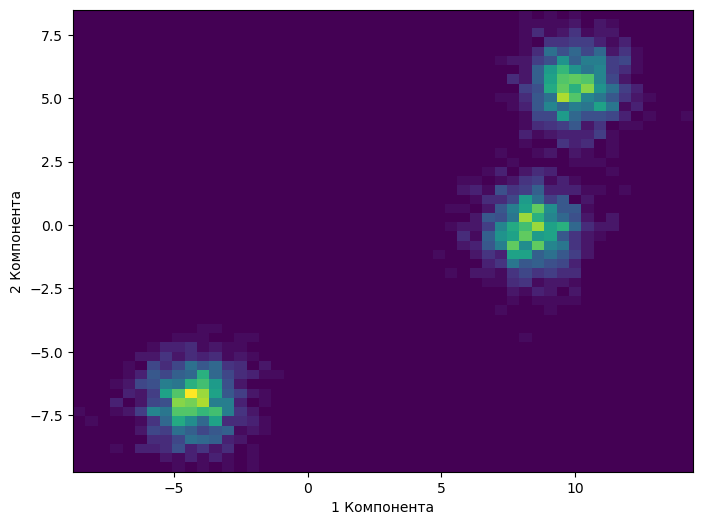

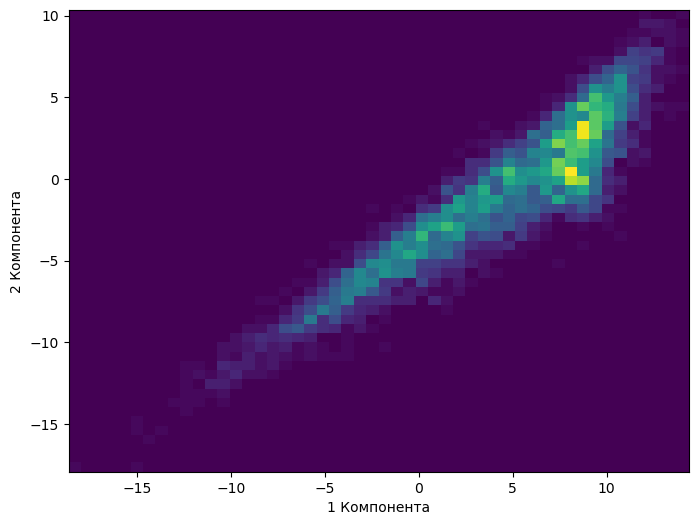

hidden_dim = 700
loss: 33.947297342936196


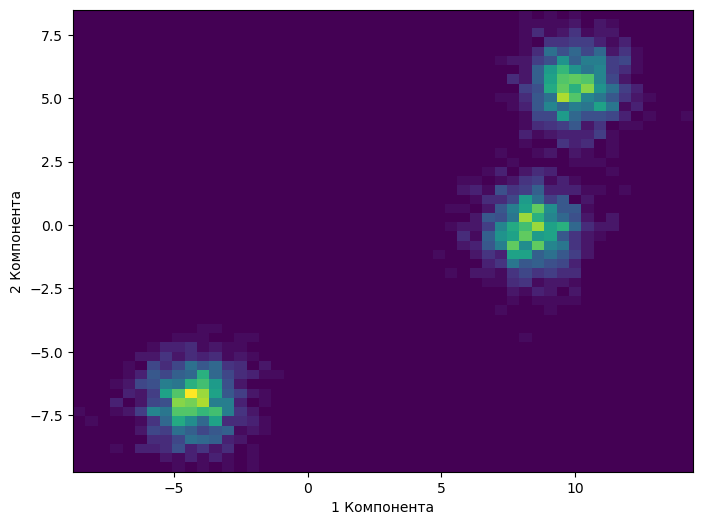

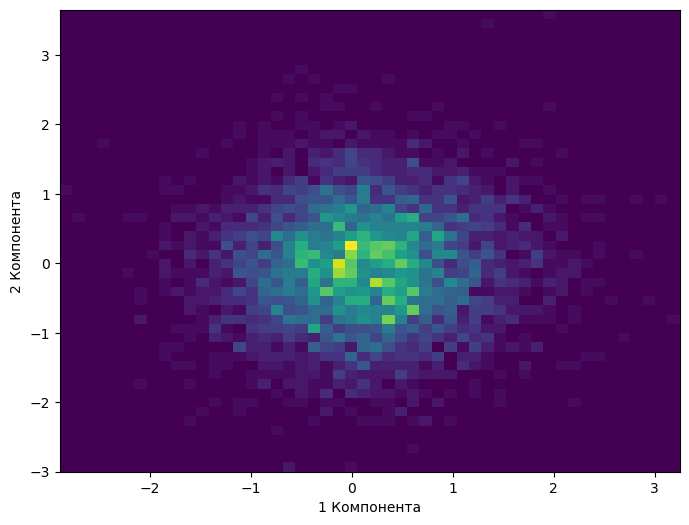

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=54.51042175292969, val_loss=49.74444616699219


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=44.71498489379883, val_loss=52.18039878336589


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=41.05104064941406, val_loss=53.304829294840495


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=39.68000030517578, val_loss=52.021851755777995


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=37.31645202636719, val_loss=53.28114294433594


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=36.007781982421875, val_loss=52.24180059814453


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=36.641082763671875, val_loss=53.571413940429686


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=33.08728790283203, val_loss=52.73929516601562


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=34.790863037109375, val_loss=52.09993948364258


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=34.062469482421875, val_loss=52.01381573486328


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=33.90728759765625, val_loss=52.62908867390951


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=33.28602981567383, val_loss=52.681505828857425


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=33.33449935913086, val_loss=52.007146830240885


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=32.57072067260742, val_loss=52.481217610677085


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=32.95577621459961, val_loss=52.24064280192057


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=32.486942291259766, val_loss=52.15130455525716


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=33.770713806152344, val_loss=52.192771016438805


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=32.321815490722656, val_loss=51.73030191040039


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=33.050498962402344, val_loss=52.68155779012044


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=31.11716651916504, val_loss=51.72870516967773


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=31.438783645629883, val_loss=52.95936916097005


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=32.38740539550781, val_loss=52.24999436442057


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=31.4180908203125, val_loss=52.98013359578451


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=31.92159080505371, val_loss=51.92112757364909


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=31.408226013183594, val_loss=52.147559051513674


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=31.348039627075195, val_loss=52.37289427693685


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=31.518404006958008, val_loss=52.54400405883789


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=31.117826461791992, val_loss=52.621980529785155


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=30.433387756347656, val_loss=52.462639760335286


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=30.287456512451172, val_loss=51.95219853719075


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=32.152652740478516, val_loss=51.76174206542969


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=29.6310977935791, val_loss=52.95382689412435


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=32.28398895263672, val_loss=52.547711079915366


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=30.214508056640625, val_loss=52.364642415364585


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=30.966144561767578, val_loss=52.04583511352539


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=31.722896575927734, val_loss=51.99043002319336


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=30.932357788085938, val_loss=52.33848475138346


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=30.1895694732666, val_loss=53.111699981689455


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=30.638092041015625, val_loss=52.46430470784505


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=30.131820678710938, val_loss=51.436677907307946


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=30.30802345275879, val_loss=52.335869303385415


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=30.64825439453125, val_loss=53.021299275716146


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=30.262866973876953, val_loss=52.26006911214193


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=30.977432250976562, val_loss=52.146170084635415


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=30.320383071899414, val_loss=52.30535442097982


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=29.394336700439453, val_loss=51.76658779907227


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=30.04953956604004, val_loss=52.66938223266602


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=29.673301696777344, val_loss=51.71382491048177


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=30.86666488647461, val_loss=51.86205689493815


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=30.473554611206055, val_loss=52.988393880208335


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=31.193836212158203, val_loss=52.895332814534505


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=30.56563949584961, val_loss=52.70624947102865


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=31.024105072021484, val_loss=52.61633239746094


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=31.190032958984375, val_loss=52.51200510660807


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=31.008737564086914, val_loss=52.773775787353514


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=29.75099754333496, val_loss=52.30548071289063


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=30.6551513671875, val_loss=52.2836008199056


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=29.569398880004883, val_loss=53.20591859944661


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=28.64202880859375, val_loss=52.085762949625654


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=30.57720947265625, val_loss=52.333734954833986


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=30.044200897216797, val_loss=52.040074930826826


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=30.21769905090332, val_loss=52.707426839192706


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 52.1808566385905


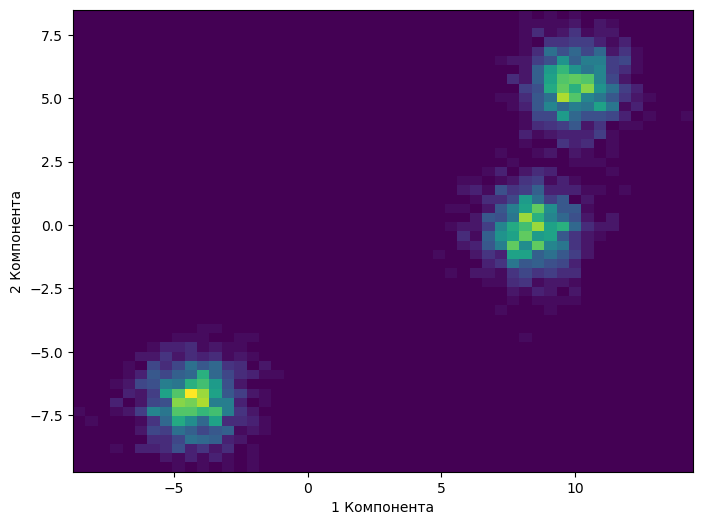

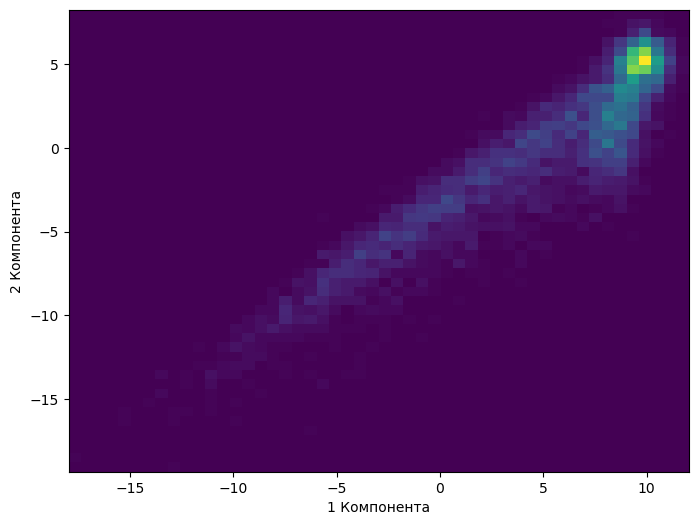

hidden_dim = 1000
loss: 33.487127482096355


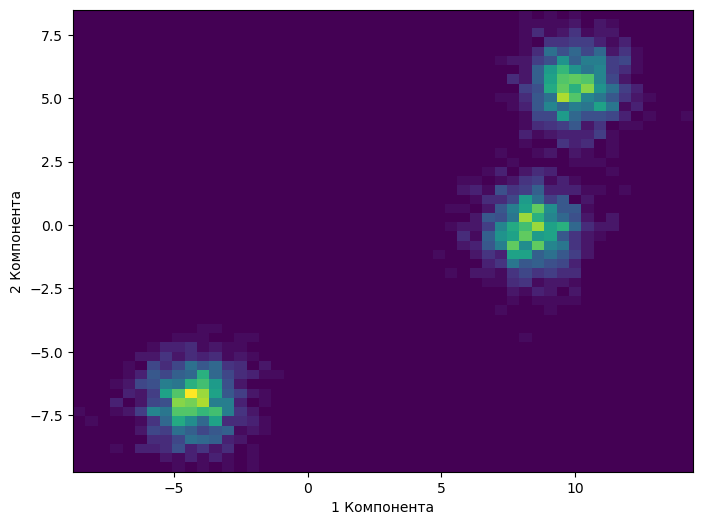

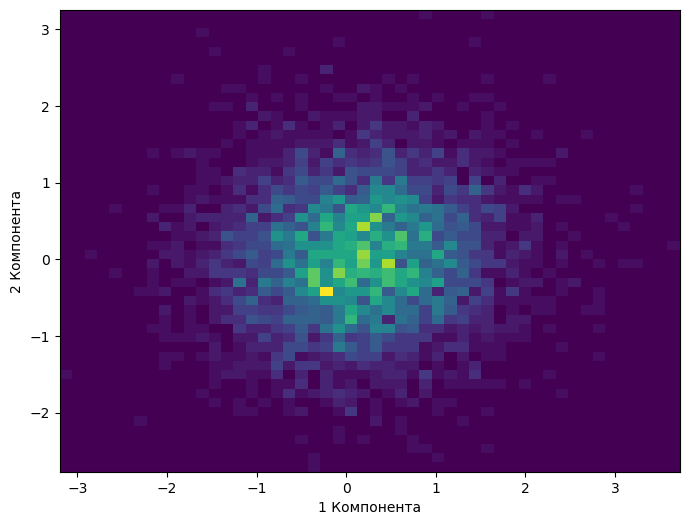

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=300, train_loss=52.35746383666992, val_loss=51.596039001464845


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=600, train_loss=44.94377517700195, val_loss=54.2608188680013


  0%|          | 0/188 [00:00<?, ?it/s]

		step=900, train_loss=40.59055709838867, val_loss=53.188157836914066


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1200, train_loss=38.44380569458008, val_loss=52.72700895182292


  0%|          | 0/188 [00:00<?, ?it/s]

		step=1500, train_loss=34.76231384277344, val_loss=52.60666564941406


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=1800, train_loss=33.66865921020508, val_loss=51.66772740681966


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2100, train_loss=34.017547607421875, val_loss=53.06701102701823


  0%|          | 0/188 [00:00<?, ?it/s]

		step=2400, train_loss=33.695556640625, val_loss=51.83953322347005


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=2700, train_loss=32.95413589477539, val_loss=52.931782786051436


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3000, train_loss=33.10198974609375, val_loss=53.70993151855469


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3300, train_loss=33.46984100341797, val_loss=52.59051652018229


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=3600, train_loss=32.781394958496094, val_loss=52.85250727335612


  0%|          | 0/188 [00:00<?, ?it/s]

		step=3900, train_loss=32.94735336303711, val_loss=53.73570622762044


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4200, train_loss=31.9003849029541, val_loss=52.11073213704427


  0%|          | 0/188 [00:00<?, ?it/s]

		step=4500, train_loss=32.223812103271484, val_loss=52.61468020629883


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=4800, train_loss=32.171356201171875, val_loss=52.20631326293945


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5100, train_loss=31.898693084716797, val_loss=52.32856598917643


  0%|          | 0/188 [00:00<?, ?it/s]

		step=5400, train_loss=30.982858657836914, val_loss=52.520586934407554


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=5700, train_loss=31.532291412353516, val_loss=51.96879583740235


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6000, train_loss=30.94881248474121, val_loss=52.74366599527995


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6300, train_loss=32.966819763183594, val_loss=52.28478838094075


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=6600, train_loss=33.67036056518555, val_loss=52.52842394002278


  0%|          | 0/188 [00:00<?, ?it/s]

		step=6900, train_loss=30.985240936279297, val_loss=52.0135366007487


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7200, train_loss=31.965173721313477, val_loss=52.63564751180013


  0%|          | 0/188 [00:00<?, ?it/s]

		step=7500, train_loss=32.19686508178711, val_loss=52.37676915486654


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=7800, train_loss=30.924726486206055, val_loss=52.598806833903


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8100, train_loss=31.010929107666016, val_loss=52.39202231852214


  0%|          | 0/188 [00:00<?, ?it/s]

		step=8400, train_loss=32.065853118896484, val_loss=52.17560903930664


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=8700, train_loss=30.67853355407715, val_loss=52.19249112955729


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9000, train_loss=29.776165008544922, val_loss=52.617356435139975


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9300, train_loss=31.131895065307617, val_loss=52.30071646118164


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=9600, train_loss=31.190839767456055, val_loss=52.03004224650065


  0%|          | 0/188 [00:00<?, ?it/s]

		step=9900, train_loss=32.173500061035156, val_loss=52.291306701660154


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10200, train_loss=32.44707107543945, val_loss=52.251768534342446


  0%|          | 0/188 [00:00<?, ?it/s]

		step=10500, train_loss=30.220172882080078, val_loss=52.48023192342122


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=10800, train_loss=29.94483184814453, val_loss=52.406972483317055


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11100, train_loss=31.403230667114258, val_loss=53.137114583333336


  0%|          | 0/188 [00:00<?, ?it/s]

		step=11400, train_loss=31.628454208374023, val_loss=51.99949241129557


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=11700, train_loss=30.18777847290039, val_loss=52.56318392944336


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12000, train_loss=30.483116149902344, val_loss=52.3404743754069


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12300, train_loss=31.812047958374023, val_loss=52.35917886352539


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=12600, train_loss=31.041000366210938, val_loss=52.72768889363607


  0%|          | 0/188 [00:00<?, ?it/s]

		step=12900, train_loss=31.19057846069336, val_loss=52.026558787027994


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13200, train_loss=31.059612274169922, val_loss=52.21569907633464


  0%|          | 0/188 [00:00<?, ?it/s]

		step=13500, train_loss=30.98737335205078, val_loss=52.292569183349606


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=13800, train_loss=31.327457427978516, val_loss=52.14648252360026


  0%|          | 0/188 [00:00<?, ?it/s]

		step=14100, train_loss=30.93282127380371, val_loss=53.05508894856771


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14400, train_loss=29.722578048706055, val_loss=52.414748260498044


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=14700, train_loss=31.55521011352539, val_loss=52.40728823852539


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15000, train_loss=30.23136329650879, val_loss=52.356936594645184


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15300, train_loss=31.044218063354492, val_loss=52.91708533732096


  0%|          | 0/188 [00:00<?, ?it/s]

		step=15600, train_loss=30.210355758666992, val_loss=52.56248296101888


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=15900, train_loss=30.800260543823242, val_loss=52.513533172607424


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16200, train_loss=30.147554397583008, val_loss=52.72636647542318


  0%|          | 0/188 [00:00<?, ?it/s]

		step=16500, train_loss=30.086071014404297, val_loss=52.52955875651042


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=16800, train_loss=30.662322998046875, val_loss=52.72569620768229


  0%|          | 0/188 [00:00<?, ?it/s]

		step=17100, train_loss=29.501134872436523, val_loss=52.99041900634766


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17400, train_loss=29.836137771606445, val_loss=52.692236602783204


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=17700, train_loss=30.1616268157959, val_loss=52.12173060099284


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18000, train_loss=30.389657974243164, val_loss=52.14269181315104


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

		step=18300, train_loss=31.04849624633789, val_loss=52.27928631591797


  0%|          | 0/188 [00:00<?, ?it/s]

		step=18600, train_loss=30.74449920654297, val_loss=52.957561350504555


  0%|          | 0/188 [00:00<?, ?it/s]

loss: 52.30520315551758


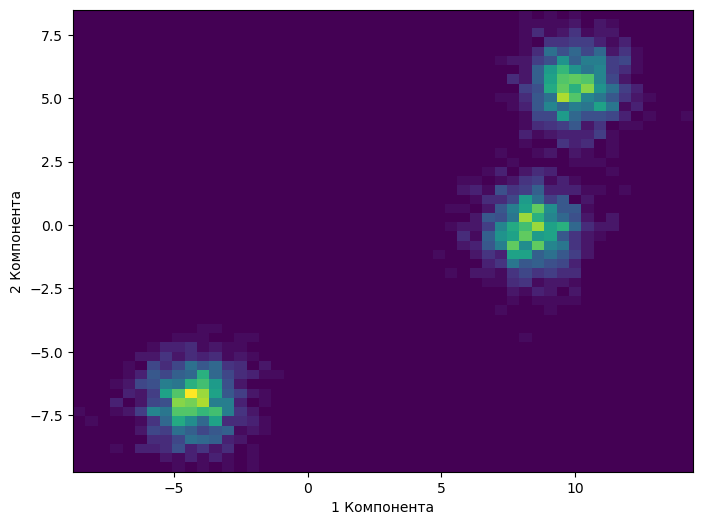

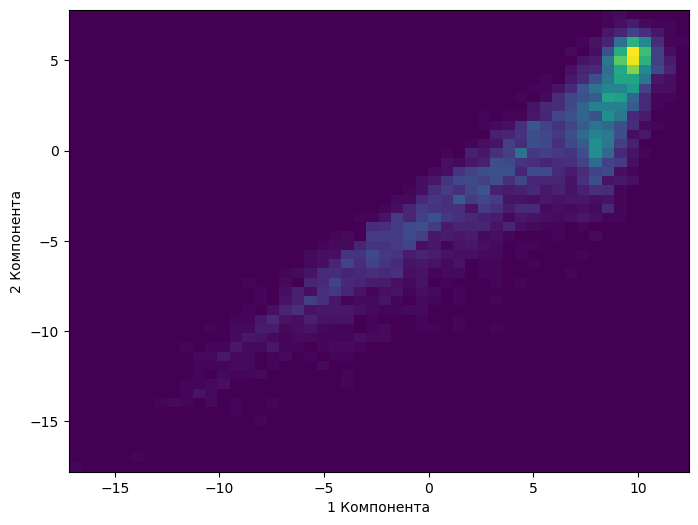

In [259]:
train_dataset, test_dataset = generate_clusters(number_clusters=3, number_samples=5000, vector_size=30)

for hidden_dim in hidden_dim_list:
    print(f'hidden_dim = {hidden_dim}')
    
    model = VAE(latent_dim=30, input_dim=30, hidden_dim=hidden_dim)
    model.to(device)
    
    writer = SummaryWriter(log_dir = f'tensorboard_4/hidden_dim_{hidden_dim}')
    call = callback(writer, test_dataset, loss_function)
    
    check(64, test_dataset, model, loss_function)
    trainer(count_of_epoch=100,
        batch_size=64, 
        dataset=train_dataset,
        model=model, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)
    check(64, test_dataset, model, loss_function)

Чем больше размерность скрытого пространства, тем лучше, но нужно больше эпох. И важно не получить переобучение.

Проведены эксперименты над моделью автоэнкодера, сделан перебор гиперпараметров.